# _Aspidoscelis marmoratus_ Male Specific Markers

## Imports and Constants

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import os
from glob import glob
from wand.image import Image as WImage
import itertools as it
from Bio import SeqIO
from sklearn.preprocessing import scale
from scipy.spatial import distance
from scipy.cluster import hierarchy
import primer3
import sys
import datetime


In [115]:
sys.path = ['../../../python_tools/fasta_class/'] + sys.path

In [2]:
%matplotlib inline
sns.set_style("whitegrid")

In [3]:
# plotting constants
minor_f_size = 14
major_f_size = 16
title_f_size = 18
notebook_fig_size = (10,8)
sns.set_context(rc={"font.size":major_f_size,"axes.titlesize":major_f_size,"axes.labelsize":minor_f_size})   


# other constants
marm_genome_size = 1639530780
read_length = 250

## Gathering Data

This family of lizards was originally sequenced in order to generate a meotic map for the _A. marmoratus_ genome assembly. Since we already have the DNAseq data for the animals, we decided to try and leverage those data in order to identify a male specific dna sequence that can be used for genotyping. In this section I will download/link to the dnaseq alignments that Aaron Odell generated. However, first I downloaded some meta data as well as the data about the original sequencing run

### Sequencing Data

This cohort of animals was sequenced across three illumina HiSeq 2500 2 lane flowcells in rapid run mode.

In [4]:
sampleReportPaths = glob('/n/analysis/Baumann/*/MOLNG-1807/*/Sample_Report.csv')
sampleReportPaths

['/n/analysis/Baumann/rmh/MOLNG-1807/H2L7VBCXYa/Sample_Report.csv',
 '/n/analysis/Baumann/rmh/MOLNG-1807/H7CN3BCXYa/Sample_Report.csv',
 '/n/analysis/Baumann/rmh/MOLNG-1807/H2WCCBCXYa/Sample_Report.csv']

In [5]:
sampleReportDfs = [pd.read_csv(path) for path in sampleReportPaths]
sampleReportDf = pd.concat(sampleReportDfs)
sampleReportDf.columns = [c.replace(' ', '_') for c in sampleReportDf.columns] # I dont like to deal with spaces in column names
sampleReportDf.head()

,output,order,order_type,lane,sample_name,library_id,illumina_index,custom_barcode,read,reference,lab,total_reads,pass_filter_reads,pass_filter_percent,align_percent,type,read_length
0,s_1_1_CGATGT.fastq.gz,MOLNG-1807,DNA-Seq (1ug),1,A.tig_17115,L24712,CGATGT,NaN,1,None,Baumann Lab,18234321,18234321,100.0,NaN,Paired Reads,251
1,s_1_2_CGATGT.fastq.gz,MOLNG-1807,DNA-Seq (1ug),1,A.tig_17115,L24712,CGATGT,NaN,2,None,Baumann Lab,18234321,18234321,100.0,NaN,Paired Reads,251
2,s_1_1_TGACCA.fastq.gz,MOLNG-1807,DNA-Seq (1ug),1,A.tig_17118,L24713,TGACCA,NaN,1,None,Baumann Lab,14017603,14017603,100.0,NaN,Paired Reads,251
3,s_1_2_TGACCA.fastq.gz,MOLNG-1807,DNA-Seq (1ug),1,A.tig_17118,L24713,TGACCA,NaN,2,None,Baumann Lab,14017603,14017603,100.0,NaN,Paired Reads,251
4,s_1_1_ACAGTG.fastq.gz,MOLNG-1807,DNA-Seq (1ug),1,A.tig_21321,L24714,ACAGTG,NaN,1,None,Baumann Lab,9493500,9493500,100.0,NaN,Paired Reads,251


In [6]:
indexToSampleDict = dict(zip(sampleReportDf.illumina_index, sampleReportDf.sample_name))
indexToSampleDict

{'ACAGTG': 'A.tig_21321',
 'ACTTGA': 'A.tig_22151',
 'ATCACG': 'A.tig_21545',
 'CAGATC': 'A.tig_21323',
 'CGATGT': 'A.tig_17115',
 'CTTGTA': 'A.tig_21544',
 'GCCAAT': 'A.tig_21322',
 'TGACCA': 'A.tig_17118',
 'TTAGGC': 'A.tig_21546'}

In [7]:
readCounts = sampleReportDf.groupby('sample_name').sum().reset_index()[['sample_name', 'total_reads']]
readCounts['total_read_pairs'] = readCounts['total_reads'] / 2
readCounts['estimated_coverage'] = (readCounts['total_reads'] * 250)/ marm_genome_size
readCounts

,sample_name,total_reads,total_read_pairs,estimated_coverage
0,A.tig_17115,233057978,116528989.0,35.537298
1,A.tig_17118,179242302,89621151.0,27.331341
2,A.tig_21321,124487662,62243831.0,18.982209
3,A.tig_21322,152940748,76470374.0,23.320811
4,A.tig_21323,193542766,96771383.0,29.511914
5,A.tig_21544,210063366,105031683.0,32.031019
6,A.tig_21545,186505874,93252937.0,28.438910
7,A.tig_21546,287261598,143630799.0,43.802410
8,A.tig_22151,241724858,120862429.0,36.858847


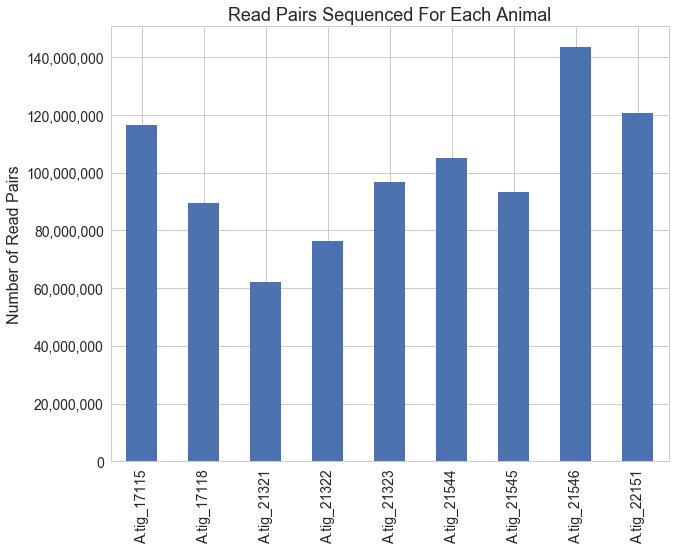

In [8]:
ax = readCounts.plot('sample_name', 
                     'total_read_pairs', 
                     kind='bar', 
                     fontsize=minor_f_size, 
                     legend=False, 
                     figsize=notebook_fig_size)

ax.yaxis.offsetText.set_fontsize(minor_f_size)
ax.set_yticklabels(['{:,}'.format(int(y)) for y in ax.get_yticks().tolist()]);
ax.set_ylabel('Number of Read Pairs', fontsize=major_f_size)
ax.set_xlabel('')
ax.set_title('Read Pairs Sequenced For Each Animal', fontsize=title_f_size)

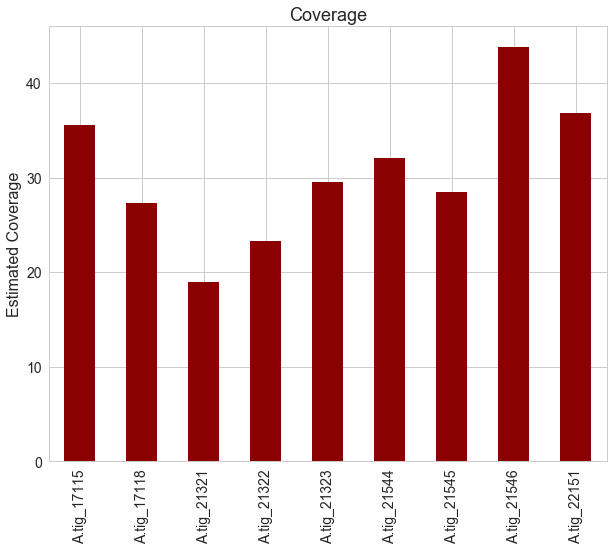

In [9]:
ax = readCounts.plot('sample_name', 
                     'estimated_coverage', 
                     kind='bar', 
                     color='darkred', 
                     fontsize=minor_f_size, 
                     legend=False, 
                     figsize=notebook_fig_size)

ax.yaxis.offsetText.set_fontsize(minor_f_size)
ax.set_yticklabels(['{:,}'.format(int(y)) for y in ax.get_yticks().tolist()]);
ax.set_ylabel('Estimated Coverage', fontsize=major_f_size)
ax.set_xlabel('')
ax.set_title('Coverage', fontsize=title_f_size)

### Meta Data

In [10]:
metaData = pd.read_excel('../data/external_data/mm_animal_meta_data_1.xlsx')
metaData.columns = [c.replace(' ', '_').lower() for c in metaData.columns]
metaData

,animal_id,sample_name,generation,letter,species,laid_by,date_hatched,hatchling_notes,gender
0,21321,A.tig_21321,F1,Z259,tig,17118.0,2016-03-29,NaN,F
1,21322,A.tig_21322,F1,Z259,tig,17118.0,2016-03-29,NaN,M
2,21323,A.tig_21323,F1,Z259,tig,17118.0,2016-03-29,NaN,M
3,21544,A.tig_21544,F1,C263,tig,17118.0,2016-04-24,NaN,F
4,21545,A.tig_21545,F1,C263,tig,17118.0,2016-04-24,NaN,M
5,21546,A.tig_21546,F1,C263,tig,17118.0,2016-04-29,NaN,F
6,22151,A.tig_22151,F1,I272,tig,17118.0,2016-06-14,hatched with opening in chest and kinked tail,NaN
7,17118,A.tig_17118,NaN,NaN,tig,NaN,NaT,NaN,F
8,17115,A.tig_17115,NaN,NaN,tig,NaN,NaT,NaN,M


In [11]:
sampleToSexDict = dict(zip(metaData.sample_name, metaData.gender))

### Alignment Files

In [12]:
alignmentPaths = glob('/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/*_merged_sorted_markDup_indelRealign.bam')
alignmentPaths

['/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/ATCACG_merged_sorted_markDup_indelRealign.bam',
 '/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/ACAGTG_merged_sorted_markDup_indelRealign.bam',
 '/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/GCCAAT_merged_sorted_markDup_indelRealign.bam',
 '/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/CTTGTA_merged_sorted_markDup_indelRealign.bam',
 '/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/CGATGT_merged_sorted_markDup_indelRealign.bam',
 '/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/ACTTGA_merged_sorted_markDup_indelRealign.bam',
 '/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/TTAGGC_merged_sorted_markDup_indelRealign.bam',
 '/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/TGACCA_merged_sorted_markDup_indelRealign.bam',
 '/n/projects/aodell/A_MARMORATA_MEIOTIC

In [13]:
alignmentIndexPaths = glob('/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/*_merged_sorted_markDup_indelRealign.bai')
alignmentIndexPaths

['/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/CGATGT_merged_sorted_markDup_indelRealign.bai',
 '/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/TGACCA_merged_sorted_markDup_indelRealign.bai',
 '/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/CAGATC_merged_sorted_markDup_indelRealign.bai',
 '/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/CTTGTA_merged_sorted_markDup_indelRealign.bai',
 '/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/ACAGTG_merged_sorted_markDup_indelRealign.bai',
 '/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/TTAGGC_merged_sorted_markDup_indelRealign.bai',
 '/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/ACTTGA_merged_sorted_markDup_indelRealign.bai',
 '/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/ATCACG_merged_sorted_markDup_indelRealign.bai',
 '/n/projects/aodell/A_MARMORATA_MEIOTIC

### Genome Assembly Reference Used

In [14]:
genomeAssemblyPath = "/n/projects/aodell/GENOMES/a_marmorata_unmasked.fasta"
genomePicardDict = "/n/projects/aodell/GENOMES/a_marmorata_unmasked.fasta.fai"

## Alignment Mapping Stats

First I am going use the local install of samtools. Here is the info about the version I used.

In [15]:
%%bash
samtools help | head


Program: samtools (Tools for alignments in the SAM format)
Version: 1.3.1 (using htslib 1.3.1)

Usage:   samtools <command> [options]

Commands:
  -- Indexing
     dict           create a sequence dictionary file
     faidx          index/extract FASTA


 Write the commands to a text file so I can parallelize the execution.

In [16]:
flagstatPathsDict = {}
with open('../bin/samtools_flagstat.txt','w') as fw:
    for bam in alignmentPaths:
        filename = os.path.basename(bam)
        flagstat = '../data/' + filename.replace('.bam', '.flagstat')
        index = filename.split("_")[0]
        sample_name = indexToSampleDict[index]
        command = 'samtools flagstat {} > {}'.format(bam, flagstat)
        flagstatPathsDict[sample_name] = flagstat
        fw.write(command + '\n')

print(len(flagstatPathsDict.keys()))

9


Run the commands in parallel. Took about 5 min. (I actually ran the command in terminal).

In [17]:
%%bash
cat ../bin/samtools_flagstat.txt
#nohup parallel --no-notice -j 9 :::: ../bin/samtools_flagstat.txt &> ../bin/samtools_flagstat.out &

samtools flagstat /n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/ATCACG_merged_sorted_markDup_indelRealign.bam > ../data/ATCACG_merged_sorted_markDup_indelRealign.flagstat
samtools flagstat /n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/ACAGTG_merged_sorted_markDup_indelRealign.bam > ../data/ACAGTG_merged_sorted_markDup_indelRealign.flagstat
samtools flagstat /n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/GCCAAT_merged_sorted_markDup_indelRealign.bam > ../data/GCCAAT_merged_sorted_markDup_indelRealign.flagstat
samtools flagstat /n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/CTTGTA_merged_sorted_markDup_indelRealign.bam > ../data/CTTGTA_merged_sorted_markDup_indelRealign.flagstat
samtools flagstat /n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/CGATGT_merged_sorted_markDup_indelRealign.bam > ../data/CGATGT_merged_sorted_markDup_indelRealign.flagstat
samtools flagstat /n/proj

Clean up the results file so that I can read them in as a csv

In [23]:
%%bash 
rm ../data/flagstat_mapped_data.csv
touch ../data/flagstat_mapped_data.csv
for file in ../data/*Realign.flagstat
 do
  echo $file
  index=$(basename $file | cut -f 1 -d '_')
  cat $file | grep "mapped (" | sed "s/ + 0 mapped (/,/" | sed "s/%.*$//" | sed "s/^/$index,/" >> ../data/flagstat_mapped_data.csv
 done

head -n 5 ../data/flagstat_mapped_data.csv

../data/ACAGTG_merged_sorted_markDup_indelRealign.flagstat
../data/ACTTGA_merged_sorted_markDup_indelRealign.flagstat
../data/ATCACG_merged_sorted_markDup_indelRealign.flagstat
../data/CAGATC_merged_sorted_markDup_indelRealign.flagstat
../data/CGATGT_merged_sorted_markDup_indelRealign.flagstat
../data/CTTGTA_merged_sorted_markDup_indelRealign.flagstat
../data/GCCAAT_merged_sorted_markDup_indelRealign.flagstat
../data/TGACCA_merged_sorted_markDup_indelRealign.flagstat
../data/TTAGGC_merged_sorted_markDup_indelRealign.flagstat
ACAGTG,121793509,94.99
ACTTGA,238250452,97.18
ATCACG,185085996,96.62
CAGATC,193085899,97.05
CGATGT,228954817,96.85


In [24]:
flagstatDF = pd.read_csv('../data/flagstat_mapped_data.csv',names=['index', 'reads_mapped', 'percent_mapped'])
flagstatDF['sample_name'] = flagstatDF['index'].apply(lambda x: indexToSampleDict[x])
flagstatDF['sex'] = flagstatDF['sample_name'].apply(lambda x: sampleToSexDict[x])
flagstatDF.sort_values('sex', inplace=True)
flagstatDF

,index,reads_mapped,percent_mapped,sample_name,sex
0,ACAGTG,121793509,94.99,A.tig_21321,F
5,CTTGTA,205882982,96.72,A.tig_21544,F
7,TGACCA,179237242,97.17,A.tig_17118,F
8,TTAGGC,282106059,97.50,A.tig_21546,F
2,ATCACG,185085996,96.62,A.tig_21545,M
3,CAGATC,193085899,97.05,A.tig_21323,M
4,CGATGT,228954817,96.85,A.tig_17115,M
6,GCCAAT,150815423,96.03,A.tig_21322,M
1,ACTTGA,238250452,97.18,A.tig_22151,NaN


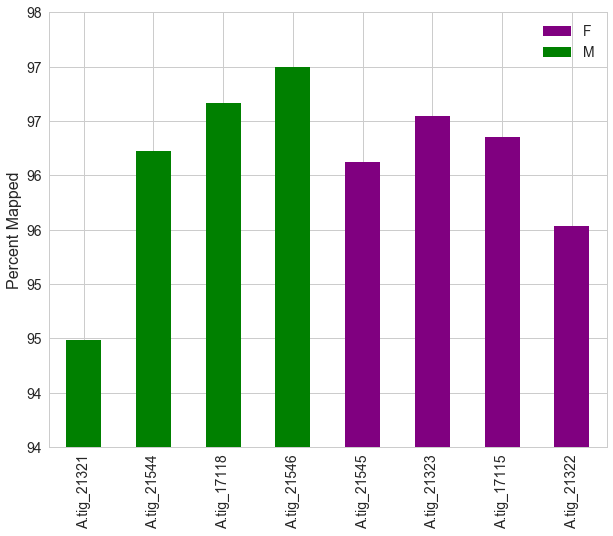

In [25]:
df = flagstatDF.dropna().copy()
df['color'] = df['sex'].apply(lambda x: 'purple' if x=='M' else 'green')
ax = df.plot('sample_name', 
             'percent_mapped', 
             kind='bar', 
             color=df['color'], 
             fontsize=minor_f_size,
             legend=False, 
             figsize=notebook_fig_size)

ax.set_ylim(94,98)
ax.yaxis.offsetText.set_fontsize(minor_f_size)
ax.set_yticklabels(['{:,}'.format(int(y)) for y in ax.get_yticks().tolist()]);
ax.set_ylabel('Percent Mapped', fontsize=major_f_size)
ax.set_xlabel('')


#legend
female = plt.Rectangle((0,0),1,1,fc="purple", edgecolor = 'none')
male = plt.Rectangle((0,0),1,1,fc='green',  edgecolor = 'none')

l = ax.legend([female, male], 
              ['F', 'M'], 
              loc=1, 
              ncol = 1, 
              fontsize=minor_f_size
              )

l.draw_frame(False)

## Extracting Unmapped Reads

In [26]:
unmappedPathsDict = {}
with open('../bin/extract_unmapped.txt','w') as fw:
    for bam in alignmentPaths:
        filename = os.path.basename(bam)
        unmapped = '../data/' + filename.replace('.bam', '.unmapped.bam')
        index = filename.split("_")[0]
        sample_name = indexToSampleDict[index]
        command = 'samtools view -@ 3 -f 12 -b {} > {}'.format(bam, unmapped)
        unmappedPathsDict[sample_name] = unmapped
        fw.write(command + '\n')

print(len(unmappedPathsDict.keys()))

9


In [27]:
%%bash
cat ../bin/extract_unmapped.txt
#nohup parallel --no-notice -j 27 :::: ../bin/extract_unmapped.txt &> ../bin/extract_unmapped.out &

samtools view -@ 3 -f 12 -b /n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/ATCACG_merged_sorted_markDup_indelRealign.bam > ../data/ATCACG_merged_sorted_markDup_indelRealign.unmapped.bam
samtools view -@ 3 -f 12 -b /n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/ACAGTG_merged_sorted_markDup_indelRealign.bam > ../data/ACAGTG_merged_sorted_markDup_indelRealign.unmapped.bam
samtools view -@ 3 -f 12 -b /n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/GCCAAT_merged_sorted_markDup_indelRealign.bam > ../data/GCCAAT_merged_sorted_markDup_indelRealign.unmapped.bam
samtools view -@ 3 -f 12 -b /n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/CTTGTA_merged_sorted_markDup_indelRealign.bam > ../data/CTTGTA_merged_sorted_markDup_indelRealign.unmapped.bam
samtools view -@ 3 -f 12 -b /n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/CGATGT_merged_sorted_markDup_indelRealign.bam > ../data/CGATGT_mer

In [28]:
sexPathsDict = {}
with open('../bin/merge_sexes.txt','w') as fw:
    male = []
    female = []
    for sample_name in unmappedPathsDict:
        if sampleToSexDict[sample_name]=='M':
            male.append(unmappedPathsDict[sample_name])
        elif sampleToSexDict[sample_name]=='F':
            female.append(unmappedPathsDict[sample_name])
        else:
            pass

            
    male_bam = '../data/male_unmapped.bam'
    female_bam = '../data/female_unmapped.bam'
    command = 'samtools merge -f {} {}'.format(male_bam, ' '.join(male))
    command2 = 'samtools merge -f {} {}'.format(female_bam, ' '.join(female))
    sexPathsDict['M'] = female_bam
    sexPathsDict['F'] = male_bam
    
    fw.write(command + '\n' + command2 + '\n')



In [29]:
%%bash
cat ../bin/merge_sexes.txt
#nohup parallel --no-notice -j 2 :::: ../bin/merge_sexes.txt &> ../bin/merge_sexes.out &

samtools merge -f ../data/male_unmapped.bam ../data/ATCACG_merged_sorted_markDup_indelRealign.unmapped.bam ../data/GCCAAT_merged_sorted_markDup_indelRealign.unmapped.bam ../data/CGATGT_merged_sorted_markDup_indelRealign.unmapped.bam ../data/CAGATC_merged_sorted_markDup_indelRealign.unmapped.bam
samtools merge -f ../data/female_unmapped.bam ../data/ACAGTG_merged_sorted_markDup_indelRealign.unmapped.bam ../data/CTTGTA_merged_sorted_markDup_indelRealign.unmapped.bam ../data/TTAGGC_merged_sorted_markDup_indelRealign.unmapped.bam ../data/TGACCA_merged_sorted_markDup_indelRealign.unmapped.bam


## Alignments Stats for Assemblies

Download Picard Tools for insert statistics.

In [30]:
%%bash
cd ../bin
#git clone https://github.com/broadinstitute/picard.git
#cd picard/
#./gradlew shadowJar
#java -jar build/libs/picard.jar

Sub sample alignments to gather insert size metrics

In [31]:
alignmentPathsDict = {indexToSampleDict[os.path.basename(path).split('_')[0]]:path for path in alignmentPaths}
alignmentPathsDict

{'A.tig_17115': '/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/CGATGT_merged_sorted_markDup_indelRealign.bam',
 'A.tig_17118': '/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/TGACCA_merged_sorted_markDup_indelRealign.bam',
 'A.tig_21321': '/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/ACAGTG_merged_sorted_markDup_indelRealign.bam',
 'A.tig_21322': '/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/GCCAAT_merged_sorted_markDup_indelRealign.bam',
 'A.tig_21323': '/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/CAGATC_merged_sorted_markDup_indelRealign.bam',
 'A.tig_21544': '/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/CTTGTA_merged_sorted_markDup_indelRealign.bam',
 'A.tig_21545': '/n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/ATCACG_merged_sorted_markDup_indelRealign.bam',
 'A.tig_21546': '/n/projects/aodell/A_MARMORATA_MEIOTIC

In [32]:
sexSubPathsDict = {'F':[], 'M':[]}

with open('../bin/sub_all_sexes.txt','w') as fw:
    for sample_name in alignmentPathsDict:
        if sampleToSexDict[sample_name]=='M' or sampleToSexDict[sample_name]=='F':
            mapped_reads = flagstatDF[flagstatDF['sample_name'] == sample_name]['reads_mapped'].iloc[0]
            perc = round(250e3/mapped_reads,6)
            out_bam = '../data/' + os.path.basename(alignmentPathsDict[sample_name]).replace('.bam','.250kSub.bam')
            command = 'samtools view -@ 2 -b -F 4 -s {} {} > {}'.format(perc, alignmentPathsDict[sample_name], out_bam)
            print(command)
            
            fw.write(command + '\n')
            sexSubPathsDict[sampleToSexDict[sample_name]].append(out_bam)
            
sexSubPathsDict   

samtools view -@ 2 -b -F 4 -s 0.001351 /n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/ATCACG_merged_sorted_markDup_indelRealign.bam > ../data/ATCACG_merged_sorted_markDup_indelRealign.250kSub.bam
samtools view -@ 2 -b -F 4 -s 0.002053 /n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/ACAGTG_merged_sorted_markDup_indelRealign.bam > ../data/ACAGTG_merged_sorted_markDup_indelRealign.250kSub.bam
samtools view -@ 2 -b -F 4 -s 0.001658 /n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/GCCAAT_merged_sorted_markDup_indelRealign.bam > ../data/GCCAAT_merged_sorted_markDup_indelRealign.250kSub.bam
samtools view -@ 2 -b -F 4 -s 0.001214 /n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/CTTGTA_merged_sorted_markDup_indelRealign.bam > ../data/CTTGTA_merged_sorted_markDup_indelRealign.250kSub.bam
samtools view -@ 2 -b -F 4 -s 0.001092 /n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/CGATGT_merged_s

{'F': ['../data/ACAGTG_merged_sorted_markDup_indelRealign.250kSub.bam',
  '../data/CTTGTA_merged_sorted_markDup_indelRealign.250kSub.bam',
  '../data/TTAGGC_merged_sorted_markDup_indelRealign.250kSub.bam',
  '../data/TGACCA_merged_sorted_markDup_indelRealign.250kSub.bam'],
 'M': ['../data/ATCACG_merged_sorted_markDup_indelRealign.250kSub.bam',
  '../data/GCCAAT_merged_sorted_markDup_indelRealign.250kSub.bam',
  '../data/CGATGT_merged_sorted_markDup_indelRealign.250kSub.bam',
  '../data/CAGATC_merged_sorted_markDup_indelRealign.250kSub.bam']}

In [33]:
%%bash
cat ../bin/sub_all_sexes.txt
#nohup parallel --no-notice -j 16 :::: ../bin/sub_all_sexes.txt &> ../bin/sub_all_sexes.out &

samtools view -@ 2 -b -F 4 -s 0.001351 /n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/ATCACG_merged_sorted_markDup_indelRealign.bam > ../data/ATCACG_merged_sorted_markDup_indelRealign.250kSub.bam
samtools view -@ 2 -b -F 4 -s 0.002053 /n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/ACAGTG_merged_sorted_markDup_indelRealign.bam > ../data/ACAGTG_merged_sorted_markDup_indelRealign.250kSub.bam
samtools view -@ 2 -b -F 4 -s 0.001658 /n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/GCCAAT_merged_sorted_markDup_indelRealign.bam > ../data/GCCAAT_merged_sorted_markDup_indelRealign.250kSub.bam
samtools view -@ 2 -b -F 4 -s 0.001214 /n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/CTTGTA_merged_sorted_markDup_indelRealign.bam > ../data/CTTGTA_merged_sorted_markDup_indelRealign.250kSub.bam
samtools view -@ 2 -b -F 4 -s 0.001092 /n/projects/aodell/A_MARMORATA_MEIOTIC_MAP/BWA/UNIFIED_GENOTYPER_BAMS/CGATGT_merged_s

Merge the subsampled alignments.

In [34]:
subSexMergeCommand1 = 'samtools merge -@ 8 -f ../data/subSexMale.bam {}'.format(' '.join(sexSubPathsDict['M']))
subSexMergeCommand2 = 'samtools merge -@ 8 -f ../data/subSexFemale.bam {}'.format(' '.join(sexSubPathsDict['F']))

In [35]:
%%bash -s "$subSexMergeCommand1" "$subSexMergeCommand2 "
echo $1
echo $2
#eval $1
#eval $2

samtools merge -@ 8 -f ../data/subSexMale.bam ../data/ATCACG_merged_sorted_markDup_indelRealign.250kSub.bam ../data/GCCAAT_merged_sorted_markDup_indelRealign.250kSub.bam ../data/CGATGT_merged_sorted_markDup_indelRealign.250kSub.bam ../data/CAGATC_merged_sorted_markDup_indelRealign.250kSub.bam
samtools merge -@ 8 -f ../data/subSexFemale.bam ../data/ACAGTG_merged_sorted_markDup_indelRealign.250kSub.bam ../data/CTTGTA_merged_sorted_markDup_indelRealign.250kSub.bam ../data/TTAGGC_merged_sorted_markDup_indelRealign.250kSub.bam ../data/TGACCA_merged_sorted_markDup_indelRealign.250kSub.bam


Run Picard Tools on the merged subsampled alignments.

In [36]:
%%bash
#java -jar ../bin/picard/build/libs/picard.jar CollectInsertSizeMetrics I=../data/subSexMale.bam O=../data/subSexMale.insert_metrics.txt H=../data/subSexMale.insert_metrics.hist.pdf M=0.05

In [37]:
%%bash
#java -jar ../bin/picard/build/libs/picard.jar CollectInsertSizeMetrics I=../data/../data/subSexFemale.bam O=../data/subSexFemale.insert_metrics.txt H=../data/subSexFemale.insert_metrics.hist.pdf M=0.05


Plots of insert size and metrics output by picard tools.

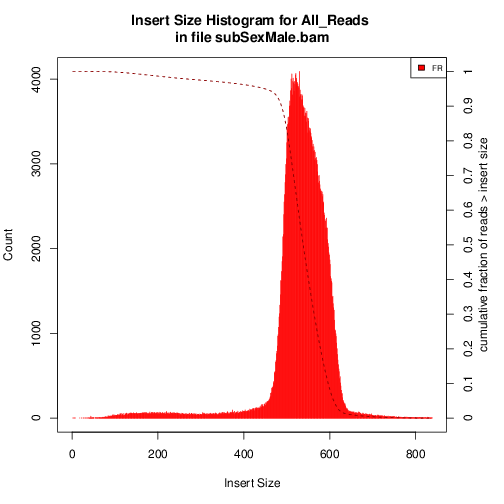

In [38]:
WImage(filename='../data/../data/subSexMale.insert_metrics.hist.pdf')

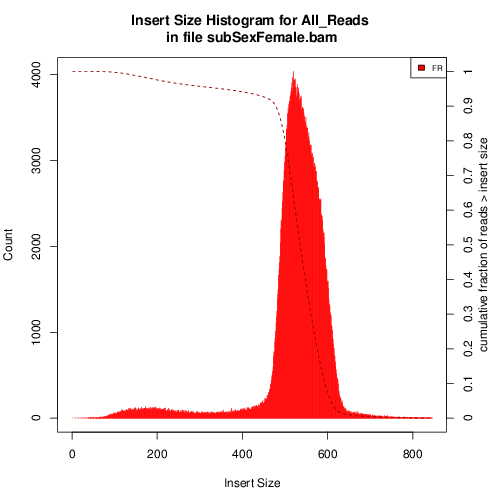

In [39]:
WImage(filename='../data/subSexFemale.insert_metrics.hist.pdf')

In [40]:
%%bash
grep -A 2 "## METRICS CLASS" ../data/subSexFemale.insert_metrics.txt | sed 1d | cut -f 1-6| column -t

MEDIAN_INSERT_SIZE  MEDIAN_ABSOLUTE_DEVIATION  MIN_INSERT_SIZE  MAX_INSERT_SIZE  MEAN_INSERT_SIZE  STANDARD_DEVIATION
535                 31                         2                72207764         523.151352        86.359569


In [41]:
%%bash
grep -A 2 "## METRICS CLASS" ../data/subSexMale.insert_metrics.txt | sed 1d | cut -f 1-6| column -t

MEDIAN_INSERT_SIZE  MEDIAN_ABSOLUTE_DEVIATION  MIN_INSERT_SIZE  MAX_INSERT_SIZE  MEAN_INSERT_SIZE  STANDARD_DEVIATION
538                 30                         2                72335463         531.725321        72.614146


In [42]:
femaleInsertSize = 535
maleInsertSize = 538

## Assemblying Unmapped Reads 127-mer

In [188]:
%%bash
cd ../bin
wget https://sourceforge.net/projects/soapdenovo2/files/SOAPdenovo2/bin/r240/SOAPdenovo2-bin-LINUX-generic-r240.tgz

In [187]:
%%bash
cd ../bin
tar -zxf SOAPdenovo2-bin-LINUX-generic-r240.tgz

#### All Male Unmapped Reads Assembly 127-mer

First I need to make the config file for the SOAP run. I copied the text from the manual and modified it in the next cell.

In [43]:
%%bash
cd ../data
ls -1 $PWD/*.bam

/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/ACAGTG_merged_sorted_markDup_indelRealign.250kSub.bam
/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/ACAGTG_merged_sorted_markDup_indelRealign.unmapped.bam
/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/ACTTGA_merged_sorted_markDup_indelRealign.unmapped.bam
/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/ATCACG_merged_sorted_markDup_indelRealign.250kSub.bam
/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/ATCACG_merged_sorted_markDup_indelRealign.unmapped.bam
/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/A.tig_17115_M_rM.bam
/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/A.tig_17118_F_rM.bam
/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/A.tig_21321_F_rM.bam
/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/A.tig_21322_M_rM.bam
/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/A.tig_21323_M_rM.bam
/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/A.tig_21544_F_rM.bam
/n/projects/dut/a_marmorata/dnaseq_sex_d

In [44]:
%%bash
#mkdir ../data/malelib
cd ../data/malelib
#ln -s ../male_unmapped.bam
ls $PWD/*

/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/malelib/male_unmapped.bam


In [45]:
maleConfig ="""
maximal read length
max_rd_len=250
[LIB]
#average insert size
avg_ins=538
#if sequence needs to be reversed, 1 for forward reverse
reverse_seq=1
#in which part(s) the reads are used
asm_flags=3
#use only first 100 bps of each read
rd_len_cutoff=250
#in which order the reads are used while scaffolding
rank=1
# cutoff of pair number for a reliable connection (at least 3 for short insert size)
pair_num_cutoff=3
#minimum aligned length to contigs for a reliable read location (at least 32 for short insert size)
map_len=32
#bam file for single or paired reads, reads 1 in paired reads file should always be followed by reads 2
#NOTE: If a read in bam file fails platform/vendor quality checks(the flag field 0x0200 is set), itself and it's paired read would be ignored.
b=/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/malelib/male_unmapped.bam
"""
with open('../bin/male_Assembly.config','w') as fw:
    fw.write(maleConfig)
print(maleConfig)


maximal read length
max_rd_len=250
[LIB]
#average insert size
avg_ins=538
#if sequence needs to be reversed, 1 for forward reverse
reverse_seq=1
#in which part(s) the reads are used
asm_flags=3
#use only first 100 bps of each read
rd_len_cutoff=250
#in which order the reads are used while scaffolding
rank=1
# cutoff of pair number for a reliable connection (at least 3 for short insert size)
pair_num_cutoff=3
#minimum aligned length to contigs for a reliable read location (at least 32 for short insert size)
map_len=32
#bam file for single or paired reads, reads 1 in paired reads file should always be followed by reads 2
#NOTE: If a read in bam file fails platform/vendor quality checks(the flag field 0x0200 is set), itself and it's paired read would be ignored.
b=/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/malelib/male_unmapped.bam



In [46]:
%%bash
cd ../bin/SOAPdenovo2-bin-LINUX-generic-r240
#nohup ./SOAPdenovo-127mer all -s ../male_Assembly.config -K 127 -R -p 20 -o male_assembly 1>ass.log 2>ass.err &
## after the assembly finished...
#mkdir ../../data/male_assembly
#mv male_assembly* ../../data/male_assembly/
#mv ass* ../../data/male_assembly/

##### All Male Kmer Freq

In [47]:
maleKmerFreqDF= pd.read_csv('../data/male_assembly/male_assembly.kmerFreq', sep ='\t', names=['Number of Distinct Kmers'])
maleKmerFreqDF = maleKmerFreqDF.reset_index()
maleKmerFreqDF.columns = ['Frequency', 'Number of Distinct Kmers']
maleKmerFreqDF['Frequency'] = maleKmerFreqDF['Frequency'] + 1 
maleKmerFreqDF.head()
maleKmerFreqDF.tail()

,Frequency,Number of Distinct Kmers
250,251,1
251,252,111
252,253,0
253,254,0
254,255,0


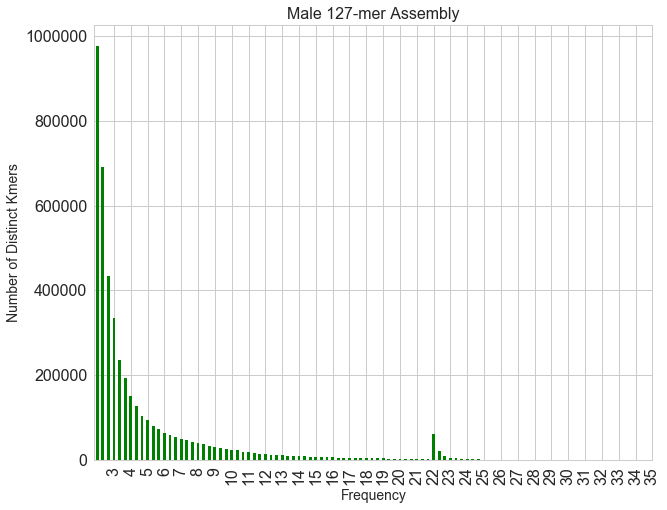

In [48]:
ax = maleKmerFreqDF[(maleKmerFreqDF['Frequency'] > 2) & (maleKmerFreqDF['Frequency'] < 100)].plot(x='Frequency', 
                                                                                                  y='Number of Distinct Kmers', 
                                                                                                  kind='bar',
                                                                                                  figsize=notebook_fig_size,
                                                                                                  fontsize=major_f_size,
                                                                                                  legend=False,
                                                                                                  title='Male 127-mer Assembly',
                                                                                                  color='green')
ax.set_xticks(np.arange(3,102,3));
ax.set_ylabel('Number of Distinct Kmers')

##### Scaffold Lengths

In [49]:
def ret_fasta_len(fasta_file):
    len_list = []
    for rec in SeqIO.parse(fasta_file, 'fasta'):
        data = {'scaffold':rec.id,
               'length':len(rec.seq)}
        len_list.append(data)
    len_df = pd.DataFrame(len_list)
    len_df.sort_values('length')
    return len_df

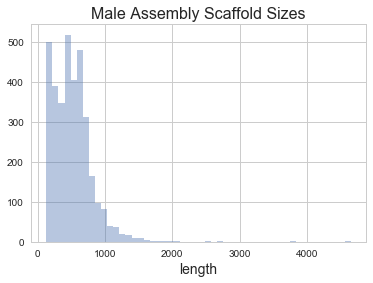

In [50]:
maleScaffoldLensDF = ret_fasta_len('../data/male_assembly/male_assembly.scafSeq')
ax = sns.distplot(maleScaffoldLensDF.length, kde=False)
ax.set_title('Male Assembly Scaffold Sizes')

In [51]:
maleScaffoldLensDF.sort_values('length', ascending=False).head()

,length,scaffold
33,4646,scaffold34
35,3760,scaffold36
3445,2726,C7127
3444,2525,C7125
3443,2105,C7123


#### All Female Unmapped Reads Assembly

First I need to make the config file for the SOAP run. I copied the text from the manual and modified it in the next cell.

In [52]:
%%bash
cd ../data
ls -1 $PWD/*.bam

/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/ACAGTG_merged_sorted_markDup_indelRealign.250kSub.bam
/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/ACAGTG_merged_sorted_markDup_indelRealign.unmapped.bam
/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/ACTTGA_merged_sorted_markDup_indelRealign.unmapped.bam
/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/ATCACG_merged_sorted_markDup_indelRealign.250kSub.bam
/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/ATCACG_merged_sorted_markDup_indelRealign.unmapped.bam
/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/A.tig_17115_M_rM.bam
/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/A.tig_17118_F_rM.bam
/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/A.tig_21321_F_rM.bam
/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/A.tig_21322_M_rM.bam
/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/A.tig_21323_M_rM.bam
/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/A.tig_21544_F_rM.bam
/n/projects/dut/a_marmorata/dnaseq_sex_d

In [53]:
%%bash
#mkdir ../data/femalelib
cd ../data/femalelib
#ln -s ../female_unmapped.bam
ls $PWD/*

/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/femalelib/female_unmapped.bam


In [54]:
femaleConfig ="""
maximal read length
max_rd_len=250
[LIB]
#average insert size
avg_ins=538
#if sequence needs to be reversed, 1 for forward reverse
reverse_seq=1
#in which part(s) the reads are used
asm_flags=3
#use only first 100 bps of each read
rd_len_cutoff=250
#in which order the reads are used while scaffolding
rank=1
# cutoff of pair number for a reliable connection (at least 3 for short insert size)
pair_num_cutoff=3
#minimum aligned length to contigs for a reliable read location (at least 32 for short insert size)
map_len=32
#bam file for single or paired reads, reads 1 in paired reads file should always be followed by reads 2
#NOTE: If a read in bam file fails platform/vendor quality checks(the flag field 0x0200 is set), itself and it's paired read would be ignored.
b=/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/femalelib/female_unmapped.bam
"""
with open('../bin/female_Assembly.config','w') as fw:
    fw.write(femaleConfig)
print(femaleConfig)


maximal read length
max_rd_len=250
[LIB]
#average insert size
avg_ins=538
#if sequence needs to be reversed, 1 for forward reverse
reverse_seq=1
#in which part(s) the reads are used
asm_flags=3
#use only first 100 bps of each read
rd_len_cutoff=250
#in which order the reads are used while scaffolding
rank=1
# cutoff of pair number for a reliable connection (at least 3 for short insert size)
pair_num_cutoff=3
#minimum aligned length to contigs for a reliable read location (at least 32 for short insert size)
map_len=32
#bam file for single or paired reads, reads 1 in paired reads file should always be followed by reads 2
#NOTE: If a read in bam file fails platform/vendor quality checks(the flag field 0x0200 is set), itself and it's paired read would be ignored.
b=/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/femalelib/female_unmapped.bam



In [55]:
%%bash
cd ../bin/SOAPdenovo2-bin-LINUX-generic-r240
#nohup ./SOAPdenovo-127mer all -s ../female_Assembly.config -K 127 -R -p 20 -o female_assembly 1>ass.log 2>ass.err &
## after the assembly finished...
#mkdir ../../data/female_assembly
#mv female_assembly* ../../data/female_assembly/
#mv ass* ../../data/female_assembly/

##### All Female Kmer Freq

In [56]:
femaleKmerFreqDF= pd.read_csv('../data/female_assembly/female_assembly.kmerFreq', sep ='\t', names=['Number of Distinct Kmers'])
femaleKmerFreqDF = femaleKmerFreqDF.reset_index()
femaleKmerFreqDF.columns = ['Frequency', 'Number of Distinct Kmers']
femaleKmerFreqDF['Frequency'] = femaleKmerFreqDF['Frequency'] + 1 
femaleKmerFreqDF.head()
femaleKmerFreqDF.tail()

,Frequency,Number of Distinct Kmers
250,251,98
251,252,7314
252,253,0
253,254,0
254,255,0


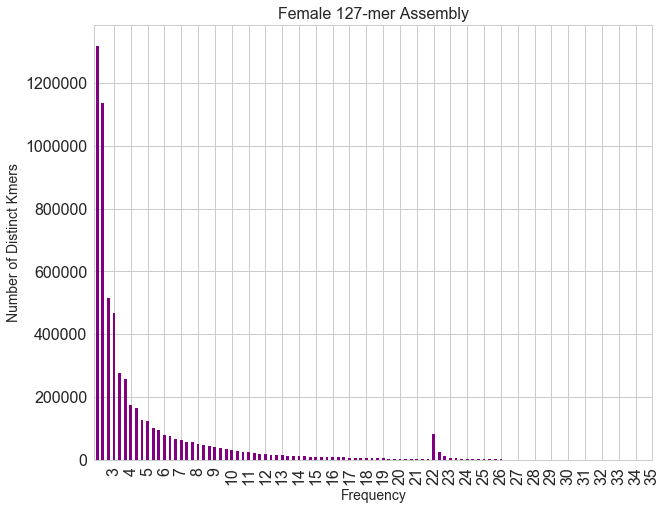

In [57]:
ax = femaleKmerFreqDF[(femaleKmerFreqDF['Frequency'] > 2) & (femaleKmerFreqDF['Frequency'] < 100)].plot(x='Frequency', 
                                                                                                        y='Number of Distinct Kmers', 
                                                                                                        kind='bar',
                                                                                                        figsize=notebook_fig_size,
                                                                                                        fontsize=major_f_size,
                                                                                                        legend=False,
                                                                                                        title='Female 127-mer Assembly',
                                                                                                        color='purple')
ax.set_xticks(np.arange(3,102,3));
ax.set_ylabel('Number of Distinct Kmers')

##### Scaffold Sizes

/home/dut/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


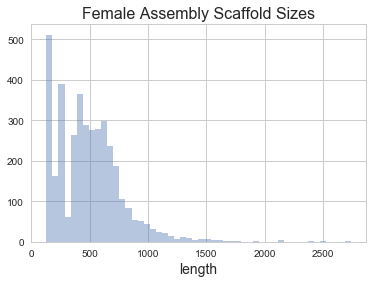

In [58]:
femaleScaffoldLensDF = ret_fasta_len('../data/female_assembly/female_assembly.scafSeq')
ax = sns.distplot(femaleScaffoldLensDF.length, kde=False)
ax.set_title('Female Assembly Scaffold Sizes')
ax.legend()

In [59]:
femaleScaffoldLensDF.length.sum(), maleScaffoldLensDF.length.sum()

(1901959, 1774579)

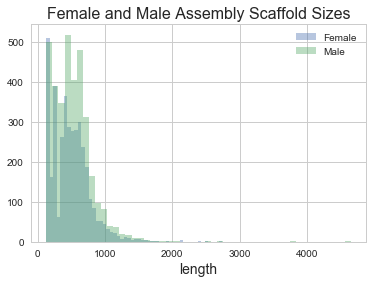

In [60]:
ax = sns.distplot(femaleScaffoldLensDF.length, kde=False, label='Female')
ax = sns.distplot(maleScaffoldLensDF.length, kde=False, ax=ax, label='Male')
ax.set_title('Female and Male Assembly Scaffold Sizes')
ax.legend()

### Aligning All Male and All Female Reads to Assemblies

I will now align unmapped reads back to the assemblies. To do this I will use the system installation of bwa mem.

In [61]:
%%bash
bwa


Program: bwa (alignment via Burrows-Wheeler transformation)
Version: 0.7.15-r1140
Contact: Heng Li <lh3@sanger.ac.uk>

Usage:   bwa <command> [options]

Command: index         index sequences in the FASTA format
         mem           BWA-MEM algorithm
         fastmap       identify super-maximal exact matches
         pemerge       merge overlapping paired ends (EXPERIMENTAL)
         aln           gapped/ungapped alignment
         samse         generate alignment (single ended)
         sampe         generate alignment (paired ended)
         bwasw         BWA-SW for long queries

         shm           manage indices in shared memory
         fa2pac        convert FASTA to PAC format
         pac2bwt       generate BWT from PAC
         pac2bwtgen    alternative algorithm for generating BWT
         bwtupdate     update .bwt to the new format
         bwt2sa        generate SA from BWT and Occ

Note: To use BWA, you need to first index the genome with `bwa index'.
      There are

Because bwa only takes fastq files as input, I will need to extract the reads from my unmapped bams. To do this I will use bedtools.

In [62]:
%%bash
bedtools bamtofastq


Tool:    bedtools bamtofastq (aka bamToFastq)
Version: v2.26.0
Summary: Convert BAM alignments to FASTQ files. 

Usage:   bamToFastq [OPTIONS] -i <BAM> -fq <FQ> 

Options:
	-fq2	FASTQ for second end.  Used if BAM contains paired-end data.
		BAM should be sorted by query name is creating paired FASTQ.

	-tags	Create FASTQ based on the mate info
		in the BAM R2 and Q2 tags.

Tips: 
	If you want to create a single, interleaved FASTQ file 
	for paired-end data, you can just write both to /dev/stdout:

	bedtools bamtofastq -i x.bam -fq /dev/stdout -fq2 /dev/stdout > x.ilv.fq



####  Converting to FQ

In [63]:
sexPathsDict

{'F': '../data/male_unmapped.bam', 'M': '../data/female_unmapped.bam'}

In [64]:
%%bash
#bedtools bamtofastq -i ../data/male_unmapped.bam -fq ../data/male_unmapped_1.fq -fq2 ../data/male_unmapped_2.fq

In [65]:
%%bash
#bedtools bamtofastq -i ../data/female_unmapped.bam -fq ../data/female_unmapped_1.fq -fq2 ../data/female_unmapped_2.fq

In [66]:
sexFqPaths = {
    'F':['../data/female_unmapped_1.fq', '../data/female_unmapped_2.fq'],
    'M':['../data/male_unmapped_1.fq', '../data/male_unmapped_2.fq']
             }

#### Index Reference

In [67]:
assemblyPaths = {
    'rF':'../data/female_assembly/female_assembly.scafSeq',
    'rM':'../data/male_assembly/male_assembly.scafSeq'
}

In [68]:
%%bash
cd ../data/female_assembly/
#bwa index female_assembly.scafSeq

In [69]:
%%bash
cd ../data/male_assembly/
#bwa index male_assembly.scafSeq

#### Aligning 

In [70]:
alignCombos = [(f, r) for f in sexFqPaths.keys() for r in assemblyPaths.keys()]
compBams = {}
with open('../bin/m_to_f_align.txt', 'w') as fw:
    for combo in alignCombos:
        out_bam = '../data/{}.bam'.format('_'.join(combo))
        temp = '../data/temp_{}'.format('_'.join(combo))
        bwa_command = 'bwa mem -t 8 {} {} {} | samtools sort -T {} -o {}'.format(
            assemblyPaths[combo[1]],
            sexFqPaths[combo[0]][0],
            sexFqPaths[combo[0]][1],
            temp,
            out_bam
        )
        compBams[combo] = out_bam
        fw.write(bwa_command + '\n')

In [71]:
%%bash
cat ../bin/m_to_f_align.txt
#parallel --no-notice -j 2 :::: ../bin/m_to_f_align.txt &> ../bin/m_to_f_align.out

bwa mem -t 8 ../data/female_assembly/female_assembly.scafSeq ../data/female_unmapped_1.fq ../data/female_unmapped_2.fq | samtools sort -T ../data/temp_F_rF -o ../data/F_rF.bam
bwa mem -t 8 ../data/male_assembly/male_assembly.scafSeq ../data/female_unmapped_1.fq ../data/female_unmapped_2.fq | samtools sort -T ../data/temp_F_rM -o ../data/F_rM.bam
bwa mem -t 8 ../data/female_assembly/female_assembly.scafSeq ../data/male_unmapped_1.fq ../data/male_unmapped_2.fq | samtools sort -T ../data/temp_M_rF -o ../data/M_rF.bam
bwa mem -t 8 ../data/male_assembly/male_assembly.scafSeq ../data/male_unmapped_1.fq ../data/male_unmapped_2.fq | samtools sort -T ../data/temp_M_rM -o ../data/M_rM.bam


In [72]:
with open('../bin/combos_index.txt', 'w') as fw:
    for combo in compBams:
        command = 'samtools index -b {}'.format(compBams[combo])
        fw.write(command + '\n')
        

In [73]:
%%bash
cat ../bin/combos_index.txt
#parallel --no-notice -j 4 :::: ../bin/combos_index.txt &> ../bin/combos_index.out

samtools index -b ../data/F_rF.bam
samtools index -b ../data/F_rM.bam
samtools index -b ../data/M_rF.bam
samtools index -b ../data/M_rM.bam


#### Generating Coverage Tracks

In [74]:
compBams

{('F', 'rF'): '../data/F_rF.bam',
 ('F', 'rM'): '../data/F_rM.bam',
 ('M', 'rF'): '../data/M_rF.bam',
 ('M', 'rM'): '../data/M_rM.bam'}

In [75]:
bedGraphs = {}
with open('../bin/bedtools_genome_cov.txt', 'w') as fw:
    for combo in compBams:
        bed = compBams[combo].replace('.bam', '.bedgraph')
        command  = 'bedtools genomecov -ibam {} -bga > {}'.format(compBams[combo], bed)
        bedGraphs[combo] = bed
        fw.write(command + '\n')

In [76]:
%%bash
cat ../bin/bedtools_genome_cov.txt
#parallel --no-notice -j 4 :::: ../bin/bedtools_genome_cov.txt &> ../bin/bedtools_genome_cov.out

bedtools genomecov -ibam ../data/F_rF.bam -bga > ../data/F_rF.bedgraph
bedtools genomecov -ibam ../data/F_rM.bam -bga > ../data/F_rM.bedgraph
bedtools genomecov -ibam ../data/M_rF.bam -bga > ../data/M_rF.bedgraph
bedtools genomecov -ibam ../data/M_rM.bam -bga > ../data/M_rM.bedgraph


#### Comparing Coverage Across Male Assembly

In [77]:
m2mCovDF = pd.read_csv('../data/M_rM.bedgraph', sep='\t', names = ['scaffold', 'start', 'stop', 'coverage'])
m2mCovDF = m2mCovDF.merge(maleScaffoldLensDF)
m2mCovDF['interval_length'] = m2mCovDF['stop'] - m2mCovDF['start']
m2mCovDF.head()

,scaffold,start,stop,coverage,length,interval_length
0,scaffold1,0,1,6,451,1
1,scaffold1,1,4,7,451,3
2,scaffold1,4,5,8,451,1
3,scaffold1,5,14,9,451,9
4,scaffold1,14,19,10,451,5


In [80]:
avgCovList = []
for scaffold in m2mCovDF[m2mCovDF.length > 1000].scaffold.unique():
    df = m2mCovDF[m2mCovDF.scaffold == scaffold]
    avg = sum(df.interval_length * df.coverage) / df.interval_length.sum()
    data = {'scaffold': scaffold, 
            'avg_cov': avg}
    avgCovList.append(data)
    
maleAvgCovDF = pd.DataFrame(avgCovList)
maleAvgCovDF = maleAvgCovDF.merge(maleScaffoldLensDF)
maleAvgCovDF.head()

,avg_cov,scaffold,length
0,2361.040028,scaffold5,1449
1,1797.411190,scaffold8,1126
2,17.358844,scaffold9,1176
3,16.534722,scaffold14,1152
4,27.088109,scaffold15,1396


In [81]:
f2mCovDF = pd.read_csv('../data/F_rM.bedgraph', sep='\t', names = ['scaffold', 'start', 'stop', 'coverage'])
f2mCovDF = f2mCovDF.merge(maleScaffoldLensDF)
f2mCovDF['interval_length'] = f2mCovDF['stop'] - f2mCovDF['start']
f2mCovDF.head()

,scaffold,start,stop,coverage,length,interval_length
0,scaffold1,0,1,7,451,1
1,scaffold1,1,32,8,451,31
2,scaffold1,32,36,9,451,4
3,scaffold1,36,44,10,451,8
4,scaffold1,44,53,11,451,9


In [82]:
avgCovList = []
for scaffold in f2mCovDF[f2mCovDF.length > 1000].scaffold.unique():
    df = f2mCovDF[f2mCovDF.scaffold == scaffold]
    avg = sum(df.interval_length * df.coverage) / df.interval_length.sum()
    data = {'scaffold': scaffold, 
            'avg_cov': avg}
    avgCovList.append(data)
    
femaleAvgCovDF = pd.DataFrame(avgCovList)
femaleAvgCovDF = femaleAvgCovDF.merge(maleScaffoldLensDF)
femaleAvgCovDF.head()

,avg_cov,scaffold,length
0,3155.336784,scaffold5,1449
1,1574.133215,scaffold8,1126
2,14.070578,scaffold9,1176
3,26.012153,scaffold14,1152
4,24.228510,scaffold15,1396


In [83]:
avgCovDf = pd.merge( maleAvgCovDF, femaleAvgCovDF, on='scaffold', how='outer',suffixes=('_male', '_female'))
avgCovDf = avgCovDf.sort_values('avg_cov_male').reset_index(drop=True)
avgCovDf.head()

,avg_cov_male,scaffold,length_male,avg_cov_female,length_female
0,7.878261,C6959,1150,52.776522,1150
1,11.104535,C7039,1301,42.129900,1301
2,11.339567,scaffold79,1016,19.390748,1016
3,11.996218,C7049,1322,20.648260,1322
4,12.269718,C6867,1027,11.884129,1027


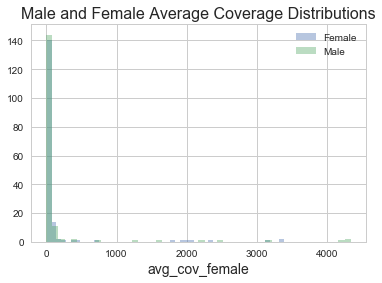

In [84]:
ax = sns.distplot(avgCovDf.avg_cov_male, kde=False, label='Female')
ax = sns.distplot(avgCovDf.avg_cov_female, kde=False, ax=ax, label='Male')
ax.set_title('Male and Female Average Coverage Distributions')
ax.legend()

In [85]:
avgCovDf['fc'] = np.log2(avgCovDf['avg_cov_male'] / avgCovDf['avg_cov_female'])

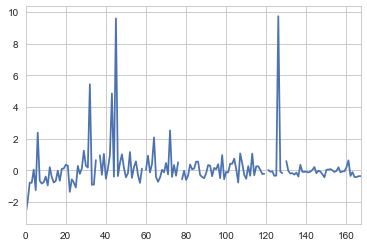

In [86]:
avgCovDf['fc'].plot()

In [87]:
avgCovDf.sort_values(['fc'],ascending=False)

,avg_cov_male,scaffold,length_male,avg_cov_female,length_female,fc
77,36.070813,C6885,1045,0.000000,1045,inf
129,63.134006,C7069,1388,0.000000,1388,inf
36,22.005900,C6859,1017,0.000000,1017,inf
59,30.333333,C6883,1044,0.000000,1044,inf
120,55.515952,C7119,2006,0.000000,2006,inf
126,60.450872,C6925,1089,0.071625,1089,9.721077
45,24.847270,C6981,1172,0.032423,1172,9.581845
32,21.204601,C7007,1217,0.489729,1217,5.436250
43,24.285586,C6941,1117,0.841540,1117,4.850925
72,34.294904,C6995,1197,5.982456,1197,2.519184


### Aligning Individual Libararies to Male Genome

#### Converting to FQ

In [88]:
unmappedFastqs={}
with open('../bin/extract_indvidual_fq.txt','w') as fw:
    for sample_name in unmappedPathsDict:
        sex = sampleToSexDict[sample_name]
        if sex =='M' or sex =='F':
            key = (sample_name, sex)
            output_1 = '../data/unmapped_{}_{}_1.fq'.format(*key)
            output_2 = '../data/unmapped_{}_{}_2.fq'.format(*key)
            command = "bedtools bamtofastq -i {} -fq {} -fq2 {}".format(
                unmappedPathsDict[sample_name],
                output_1,
                output_2
                )
            fw.write(command + '\n')
            unmappedFastqs[key] = [output_1, output_2]

In [89]:
%%bash
cat ../bin/extract_indvidual_fq.txt
#parallel --no-notice -j 8 :::: ../bin/extract_indvidual_fq.txt &> ../bin/extract_indvidual_fq.out

bedtools bamtofastq -i ../data/ATCACG_merged_sorted_markDup_indelRealign.unmapped.bam -fq ../data/unmapped_A.tig_21545_M_1.fq -fq2 ../data/unmapped_A.tig_21545_M_2.fq
bedtools bamtofastq -i ../data/ACAGTG_merged_sorted_markDup_indelRealign.unmapped.bam -fq ../data/unmapped_A.tig_21321_F_1.fq -fq2 ../data/unmapped_A.tig_21321_F_2.fq
bedtools bamtofastq -i ../data/GCCAAT_merged_sorted_markDup_indelRealign.unmapped.bam -fq ../data/unmapped_A.tig_21322_M_1.fq -fq2 ../data/unmapped_A.tig_21322_M_2.fq
bedtools bamtofastq -i ../data/CTTGTA_merged_sorted_markDup_indelRealign.unmapped.bam -fq ../data/unmapped_A.tig_21544_F_1.fq -fq2 ../data/unmapped_A.tig_21544_F_2.fq
bedtools bamtofastq -i ../data/CGATGT_merged_sorted_markDup_indelRealign.unmapped.bam -fq ../data/unmapped_A.tig_17115_M_1.fq -fq2 ../data/unmapped_A.tig_17115_M_2.fq
bedtools bamtofastq -i ../data/TTAGGC_merged_sorted_markDup_indelRealign.unmapped.bam -fq ../data/unmapped_A.tig_21546_F_1.fq -fq2 ../data/unmapped_A.tig_21546_F_2.f

#### Aligning

In [90]:
indvBams = {}
with open('../bin/indv_to_male_align.txt', 'w') as fw:
    for key in unmappedFastqs:
        out_bam = '../data/{}_{}_rM.bam'.format(*key)
        temp = '../data/temp_{}_{}_rM_'.format(*key)
        stdout = '../data/{}_{}_rM.out'.format(*key)
        bwa_command = 'bwa mem -t 8 {} {} {} | samtools sort -T {} -o {} &> {}'.format(
            assemblyPaths['rM'],
            unmappedFastqs[key][0],
            unmappedFastqs[key][1],
            temp,
            out_bam,
            stdout,
        )
        indvBams[key] = out_bam
        fw.write(bwa_command + '\n')

In [91]:
%%bash
cat ../bin/indv_to_male_align.txt
#parallel --no-notice -j 4 :::: ../bin/indv_to_male_align.txt &> ../bin/indv_to_male_align.out

bwa mem -t 8 ../data/male_assembly/male_assembly.scafSeq ../data/unmapped_A.tig_21545_M_1.fq ../data/unmapped_A.tig_21545_M_2.fq | samtools sort -T ../data/temp_A.tig_21545_M_rM_ -o ../data/A.tig_21545_M_rM.bam &> ../data/A.tig_21545_M_rM.out
bwa mem -t 8 ../data/male_assembly/male_assembly.scafSeq ../data/unmapped_A.tig_21321_F_1.fq ../data/unmapped_A.tig_21321_F_2.fq | samtools sort -T ../data/temp_A.tig_21321_F_rM_ -o ../data/A.tig_21321_F_rM.bam &> ../data/A.tig_21321_F_rM.out
bwa mem -t 8 ../data/male_assembly/male_assembly.scafSeq ../data/unmapped_A.tig_21322_M_1.fq ../data/unmapped_A.tig_21322_M_2.fq | samtools sort -T ../data/temp_A.tig_21322_M_rM_ -o ../data/A.tig_21322_M_rM.bam &> ../data/A.tig_21322_M_rM.out
bwa mem -t 8 ../data/male_assembly/male_assembly.scafSeq ../data/unmapped_A.tig_21544_F_1.fq ../data/unmapped_A.tig_21544_F_2.fq | samtools sort -T ../data/temp_A.tig_21544_F_rM_ -o ../data/A.tig_21544_F_rM.bam &> ../data/A.tig_21544_F_rM.out
bwa mem -t 8 ../data/male_as

In [92]:
with open('../bin/indv_to_male_index.txt', 'w') as fw:
    for key in indvBams:
        command = 'samtools index -b {}'.format(indvBams[key])
        fw.write(command + '\n')
        


In [93]:
%%bash
cat ../bin/indv_to_male_index.txt
#parallel --no-notice -j 8 :::: ../bin/indv_to_male_index.txt &> ../bin/indv_to_male_index.out

samtools index -b ../data/A.tig_21545_M_rM.bam
samtools index -b ../data/A.tig_21321_F_rM.bam
samtools index -b ../data/A.tig_21322_M_rM.bam
samtools index -b ../data/A.tig_21544_F_rM.bam
samtools index -b ../data/A.tig_17115_M_rM.bam
samtools index -b ../data/A.tig_21546_F_rM.bam
samtools index -b ../data/A.tig_17118_F_rM.bam
samtools index -b ../data/A.tig_21323_M_rM.bam


In [94]:
%%bash
rm ../data/flagstat_indv_data.csv
touch ../data/flagstat_indv_data.csv
for file in ../data/A.tig_*_*_rM.bam
 do
  sample=$(basename $file | sed 's/.bam//')
  flagstat=$(echo $file | sed 's/.bam/.flagstat/')
  echo $file
  echo $sample
  samtools flagstat $file > $flagstat 
  grep "mapped (" $flagstat | sed "s/ + 0 mapped (/,/" | sed "s/%.*$//" | sed "s/^/$sample,/" >> ../data/flagstat_indv_data.csv
 done

head -n 5 ../data/flagstat_indv_data.csv

../data/A.tig_17115_M_rM.bam
A.tig_17115_M_rM
../data/A.tig_17118_F_rM.bam
A.tig_17118_F_rM
../data/A.tig_21321_F_rM.bam
A.tig_21321_F_rM
../data/A.tig_21322_M_rM.bam
A.tig_21322_M_rM
../data/A.tig_21323_M_rM.bam
A.tig_21323_M_rM
../data/A.tig_21544_F_rM.bam
A.tig_21544_F_rM
../data/A.tig_21545_M_rM.bam
A.tig_21545_M_rM
../data/A.tig_21546_F_rM.bam
A.tig_21546_F_rM
A.tig_17115_M_rM,724129,10.20
A.tig_17118_F_rM,543842,11.00
A.tig_21321_F_rM,749486,12.00
A.tig_21322_M_rM,774808,12.94
A.tig_21323_M_rM,793697,14.20


In [95]:
normFactorsDF = pd.read_csv('../data/flagstat_indv_data.csv', names = ['alignment','mapped_reads','percent_mapped'])
normFactorsDF['sample_name'] = normFactorsDF['alignment'].apply(lambda x: '_'.join(x.split('_')[:2]))
normFactorsDF['sex'] = normFactorsDF['alignment'].apply(lambda x: x.split('_')[2])


normFactorsDF

,alignment,mapped_reads,percent_mapped,sample_name,sex
0,A.tig_17115_M_rM,724129,10.20,A.tig_17115,M
1,A.tig_17118_F_rM,543842,11.00,A.tig_17118,F
2,A.tig_21321_F_rM,749486,12.00,A.tig_21321,F
3,A.tig_21322_M_rM,774808,12.94,A.tig_21322,M
4,A.tig_21323_M_rM,793697,14.20,A.tig_21323,M
5,A.tig_21544_F_rM,964352,14.41,A.tig_21544,F
6,A.tig_21545_M_rM,851393,13.71,A.tig_21545,M
7,A.tig_21546_F_rM,1271911,18.61,A.tig_21546,F


#### Generating Coverage Tracks

In [96]:
indvBedGraphs = {}
with open('../bin/indv_bedtools_genome_cov.txt', 'w') as fw:
    for key in indvBams:
        bed = indvBams[key].replace('.bam', '.bedgraph')
        command  = 'bedtools genomecov -ibam {} -bga > {}'.format(indvBams[key], bed)
        indvBedGraphs[key] = bed
        fw.write(command + '\n')

In [97]:
%%bash
cat ../bin/indv_bedtools_genome_cov.txt
#parallel --no-notice -j 8 :::: ../bin/indv_bedtools_genome_cov.txt &> ../bin/indv_bedtools_genome_cov.out

bedtools genomecov -ibam ../data/A.tig_21545_M_rM.bam -bga > ../data/A.tig_21545_M_rM.bedgraph
bedtools genomecov -ibam ../data/A.tig_21321_F_rM.bam -bga > ../data/A.tig_21321_F_rM.bedgraph
bedtools genomecov -ibam ../data/A.tig_21322_M_rM.bam -bga > ../data/A.tig_21322_M_rM.bedgraph
bedtools genomecov -ibam ../data/A.tig_21544_F_rM.bam -bga > ../data/A.tig_21544_F_rM.bedgraph
bedtools genomecov -ibam ../data/A.tig_17115_M_rM.bam -bga > ../data/A.tig_17115_M_rM.bedgraph
bedtools genomecov -ibam ../data/A.tig_21546_F_rM.bam -bga > ../data/A.tig_21546_F_rM.bedgraph
bedtools genomecov -ibam ../data/A.tig_17118_F_rM.bam -bga > ../data/A.tig_17118_F_rM.bedgraph
bedtools genomecov -ibam ../data/A.tig_21323_M_rM.bam -bga > ../data/A.tig_21323_M_rM.bedgraph


#### Load In Coverage Files

In [98]:
allSampList = []
for key in indvBedGraphs:
    mapped_reads = normFactorsDF[normFactorsDF['sample_name']==key[0]]['mapped_reads'].iloc[0]
    df = pd.read_csv(indvBedGraphs[key], sep='\t', names = ['scaffold', 'start', 'stop', 'coverage'])
    df['interval_length'] = df.stop - df.start
    for scaffold in df.scaffold.unique():
        sdf = df[df.scaffold == scaffold]
        
        avg = ((sum(sdf.interval_length * sdf.coverage) / sdf.interval_length.sum()) / mapped_reads) * 1e6
        
        data = {'scaffold': scaffold, 'avg_cov': avg, 'sample_name':key[0], 'sex':key[1]}
        
        allSampList.append(data)

allSampsAvgDf = pd.DataFrame(allSampList)
allSampsAvgDf.head()

,avg_cov,sample_name,scaffold,sex
0,3.586141,A.tig_21545,scaffold1,M
1,3.778757,A.tig_21545,scaffold2,M
2,4.216106,A.tig_21545,scaffold3,M
3,6.164294,A.tig_21545,scaffold4,M
4,862.024958,A.tig_21545,scaffold5,M


In [99]:
allSampsAvgDf.head()

,avg_cov,sample_name,scaffold,sex
0,3.586141,A.tig_21545,scaffold1,M
1,3.778757,A.tig_21545,scaffold2,M
2,4.216106,A.tig_21545,scaffold3,M
3,6.164294,A.tig_21545,scaffold4,M
4,862.024958,A.tig_21545,scaffold5,M


In [100]:
allSampsAvgDf = allSampsAvgDf.merge(maleScaffoldLensDF)
allSampsAvgDf.head()

,avg_cov,sample_name,scaffold,sex,length
0,3.586141,A.tig_21545,scaffold1,M,451
1,0.106503,A.tig_21321,scaffold1,F,451
2,3.316750,A.tig_21322,scaffold1,M,451
3,2.805096,A.tig_21544,scaffold1,F,451
4,1.674923,A.tig_17115,scaffold1,M,451


In [101]:
allSampsAvgDf = allSampsAvgDf.sort_values('length', ascending=False)
allSampsAvgDf.head()

,avg_cov,sample_name,scaffold,sex,length
267,1226.652593,A.tig_21544,scaffold34,F,4646
265,1073.736011,A.tig_21321,scaffold34,F,4646
266,1076.089569,A.tig_21322,scaffold34,M,4646
268,760.383873,A.tig_17115,scaffold34,M,4646
269,1247.072896,A.tig_21546,scaffold34,F,4646


In [102]:
allSampsAvgDf['sex_name'] = allSampsAvgDf.apply(lambda x: '_'.join([x['sex'], x['sample_name']]), axis=1)

#### Clustering and Identification of >=1Kb Shared Male Contigs/Scaffolds

In [103]:
pivAvgCov = allSampsAvgDf[allSampsAvgDf['length'] > 1000].pivot(index='scaffold', columns='sex_name', values='avg_cov').reset_index()
pivAvgCov = pivAvgCov.merge(maleScaffoldLensDF)
pivAvgCov.sort_values('length', ascending=False, inplace=True)
pivAvgCov = pivAvgCov.set_index('scaffold')
pivAvgCov

,F_A.tig_17118,F_A.tig_21321,F_A.tig_21544,F_A.tig_21546,M_A.tig_17115,M_A.tig_21322,M_A.tig_21323,M_A.tig_21545,length
scaffold,,,,,,,,,
scaffold34,1395.921579,1073.736011,1226.652593,1247.072896,760.383873,1076.089569,1286.891138,1147.491726,4646
scaffold36,810.090376,631.046307,731.777908,695.487032,444.348945,616.281025,755.770015,666.425368,3760
C7127,0.000000,10.618674,0.000000,13.547993,19.544821,0.000000,0.000000,0.000000,2726
C7125,17.339049,12.366495,24.610791,0.000000,20.922917,15.052212,29.413923,15.717050,2525
C7123,37.711805,14.268528,19.764912,10.023259,19.267968,19.728127,15.996579,9.289792,2105
C7121,18.235811,8.888464,0.000000,12.665189,0.000000,0.316037,14.907285,8.316541,2046
C7119,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.461638,64.775669,2006
C7117,38.956946,21.788658,25.149309,26.448646,37.753493,24.135142,27.286284,26.797969,1974
C7115,57.053511,27.361103,31.870241,36.641792,51.255377,35.665242,36.449376,41.716539,1922


In [104]:
normPivAvgCov = pivAvgCov.filter(regex='A.tig')
normPivAvgCov = normPivAvgCov.apply(lambda row: scale(row, copy=True), axis=1)
normPivAvgCov.head()

,F_A.tig_17118,F_A.tig_21321,F_A.tig_21544,F_A.tig_21546,M_A.tig_17115,M_A.tig_21322,M_A.tig_21323,M_A.tig_21545
scaffold,,,,,,,,
scaffold34,1.360612,-0.434942,0.417269,0.531072,-2.181267,-0.421826,0.752980,-0.023898
scaffold36,1.355653,-0.363497,0.603710,0.255252,-2.156132,-0.505271,0.834078,-0.023793
C7127,-0.737203,0.695486,-0.737203,1.090714,1.899816,-0.737203,-0.737203,-0.737203
C7125,0.049898,-0.553445,0.932212,-2.053928,0.484745,-0.227574,1.514998,-0.146906
C7123,2.339676,-0.479571,0.181414,-0.990099,0.121653,0.176991,-0.271759,-1.078305


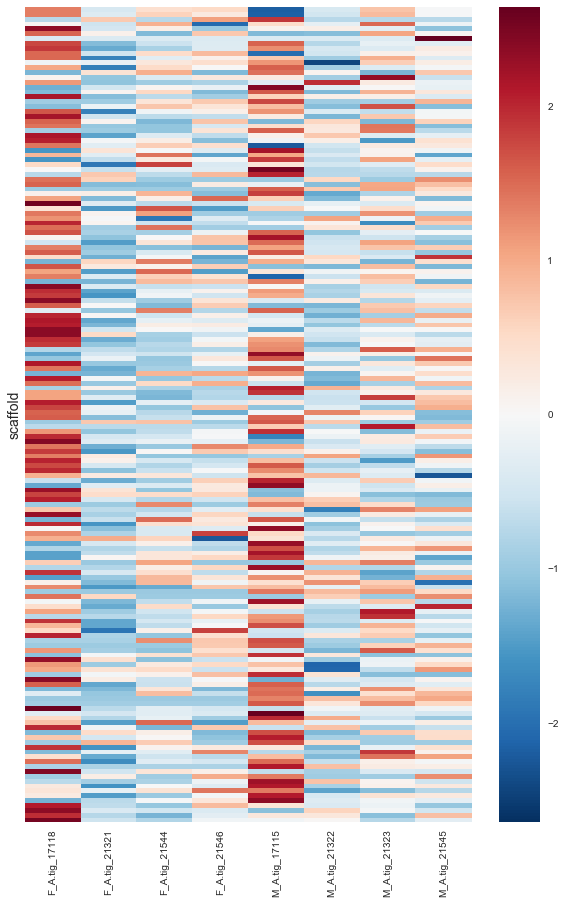

In [105]:
fig, ax = plt.subplots(figsize=(10,15))
ax = sns.heatmap(normPivAvgCov, 
                 yticklabels=False,
                 ax=ax)
plt.xticks(rotation=90);

/home/dut/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


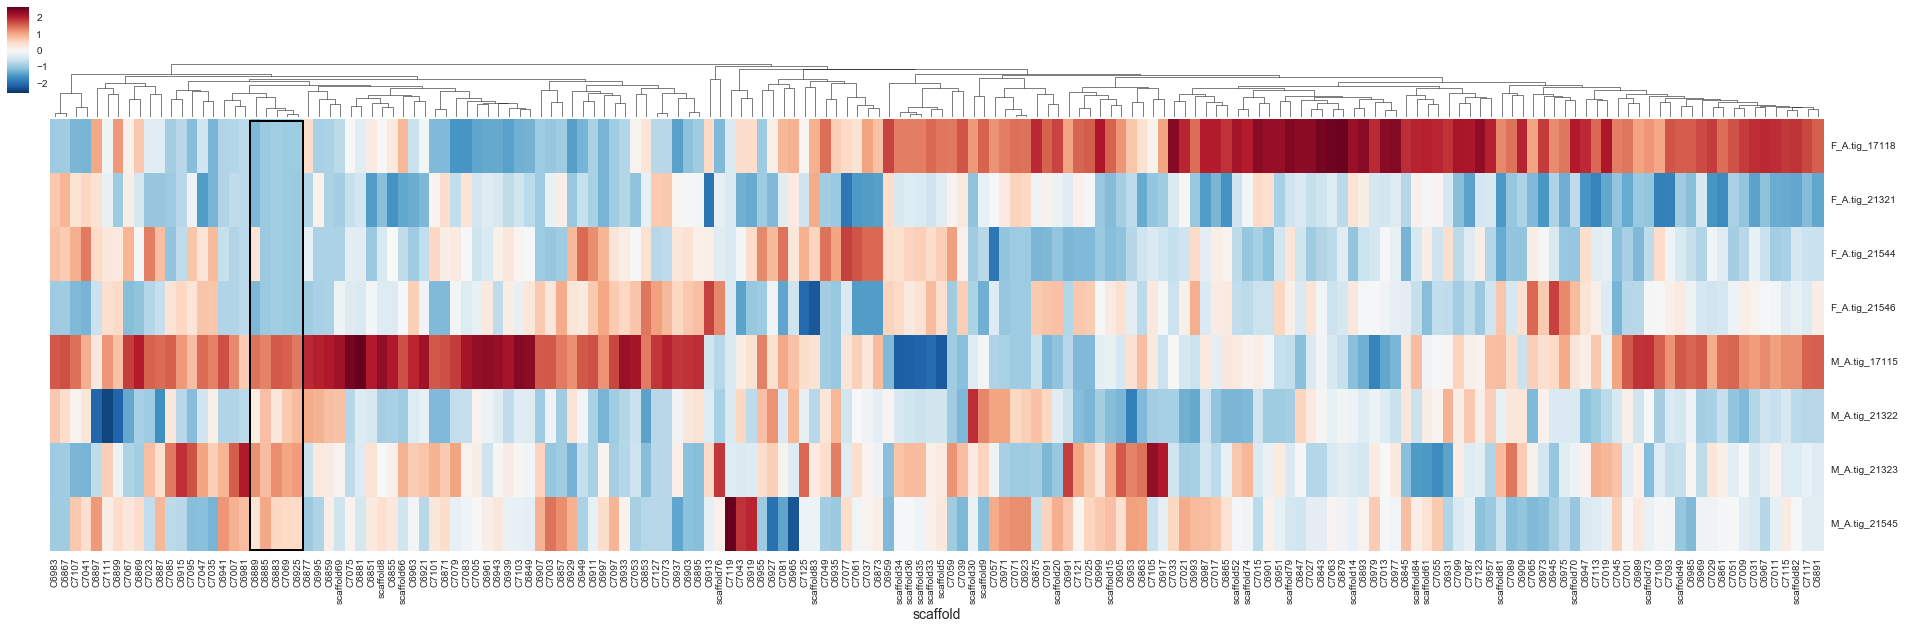

In [106]:
g = sns.clustermap(normPivAvgCov.T,
               yticklabels=True,
               col_cluster=True,
                row_cluster=False,
#                figsize=(25, 8)
                  )

hm = g.ax_heatmap.get_position()
g.ax_heatmap.add_patch(Rectangle((19, 0.01), 5, 7.95, fill=False, edgecolor='black', lw=2))


g.ax_heatmap.set_position([hm.x0-0.1, hm.y0, hm.width*4, hm.height])
col = g.ax_col_dendrogram.get_position()
g.ax_col_dendrogram.set_position([col.x0-0.1, col.y0, col.width*4, col.height*0.5])

plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0);

In [107]:
heatMapMaleScaffolds = ['C6889', 'C6885', 'C6883', 'C7069','C6925']
heatMapMaleScaffoldsStr = ' '.join(heatMapMaleScaffolds)

#### Data For Candidate Scaffolds

In [108]:
canDf = allSampsAvgDf[allSampsAvgDf.scaffold.isin(heatMapMaleScaffolds)]
canDf.head()

,avg_cov,sample_name,scaffold,sex,length,sex_name
23506,17.442269,A.tig_21322,C7069,M,1388,M_A.tig_21322
23507,0.000000,A.tig_21544,C7069,F,1388,F_A.tig_21544
23508,26.863238,A.tig_17115,C7069,M,1388,M_A.tig_17115
23509,0.000000,A.tig_21546,C7069,F,1388,F_A.tig_21546
23510,0.000000,A.tig_17118,C7069,F,1388,F_A.tig_17118


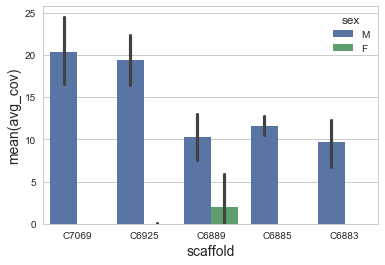

In [109]:
sns.barplot(x='scaffold', y='avg_cov', hue='sex',data = canDf)

In [253]:
df_list = []
for key in indvBedGraphs:
    mapped_reads = normFactorsDF[normFactorsDF['sample_name']==key[0]]['mapped_reads'].iloc[0]
    df = pd.read_csv(indvBedGraphs[key], sep='\t', names = ['scaffold', 'start', 'stop', 'coverage'])
    df = df[df.scaffold.isin(heatMapMaleScaffolds)]
    df['sample_name'] = key[0]
    df['sex'] = key[1]
    df['sex_name'] = '_'.join(key)
    df_list.append(df)
    df = None

canScaffoldsCovDf =pd.concat(df_list).reset_index(drop=True)
canScaffoldsCovDf.head()

,scaffold,start,stop,coverage,sample_name,sex,sex_name
0,C6883,0,3,2,A.tig_21545,M,A.tig_21545_M
1,C6883,3,9,3,A.tig_21545,M,A.tig_21545_M
2,C6883,9,43,4,A.tig_21545,M,A.tig_21545_M
3,C6883,43,89,5,A.tig_21545,M,A.tig_21545_M
4,C6883,89,115,6,A.tig_21545,M,A.tig_21545_M


In [266]:
maleScaffoldLensDF[maleScaffoldLensDF.scaffold == scaffold].length.iloc[0]

1044

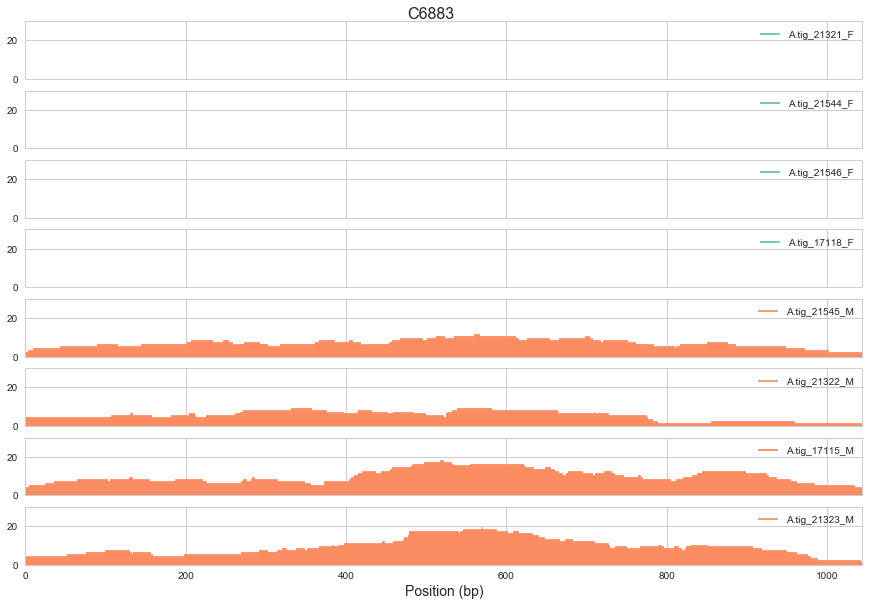

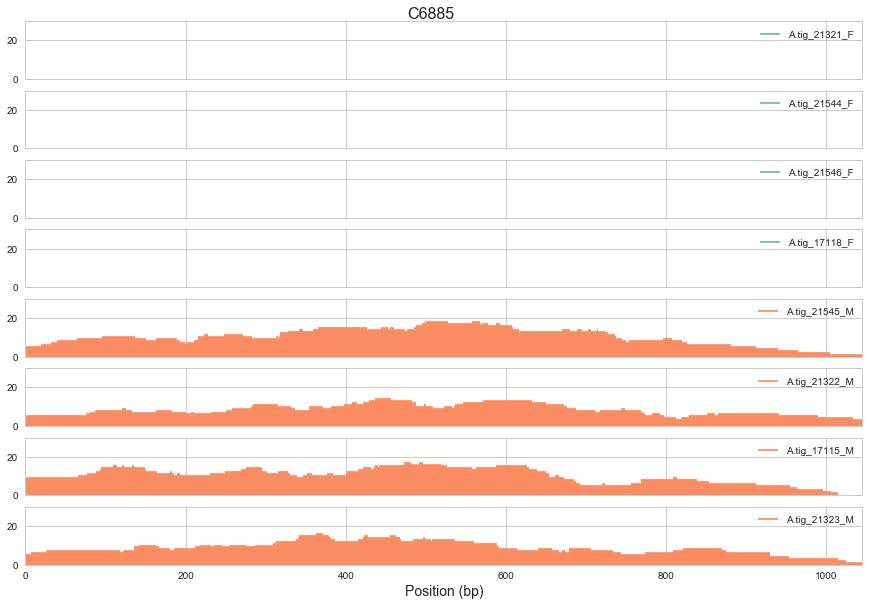

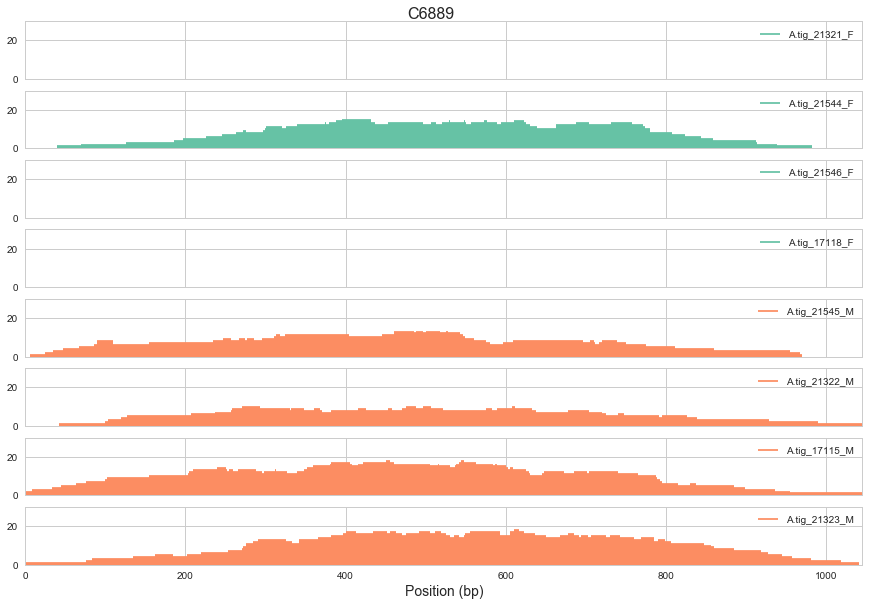

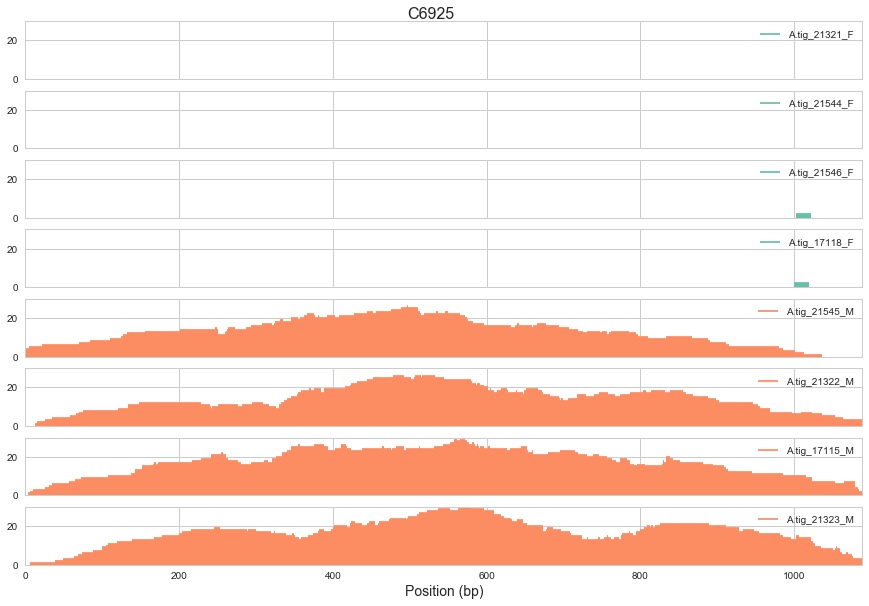

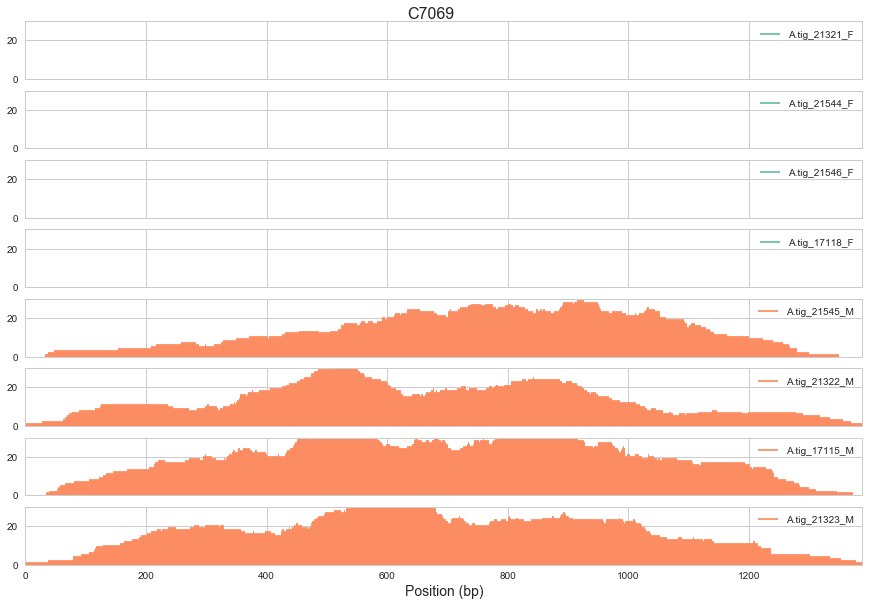

In [279]:
colorsDict = dict(zip(['F','M'], ['#66c2a5', '#fc8d62'])) 
for scaffold in canScaffoldsCovDf.scaffold.unique():
    fig, axarr = plt.subplots(8, 1, figsize=(15,10))
    fig.suptitle(scaffold, fontsize=16, y=0.90)
    for i, sex_name in enumerate(sorted(canScaffoldsCovDf.sex_name.unique(), key=lambda x: x[-1])):
        data = canScaffoldsCovDf[(canScaffoldsCovDf.scaffold==scaffold) & (canScaffoldsCovDf.sex_name == sex_name) & (canScaffoldsCovDf.coverage > 0)].reset_index(drop=True)
        ax = axarr[i]
        ax.set_ylim(0,30)
        ax.set_xlim(0, maleScaffoldLensDF[maleScaffoldLensDF.scaffold == scaffold].length.iloc[0])
        ax.hlines(y=data.coverage, xmin=data.start, xmax=data.stop, color=colorsDict[sex_name[-1]], label=sex_name)
        for k,x in enumerate(zip(data.start, data.stop)):
            ax.fill_between(x=x, y1=data.coverage.iloc[k], y2=0, color=colorsDict[sex_name[-1]],alpha=1.0, lw=0)
        if i != 7:
            ax.xaxis.set_ticklabels([])
        else:
            ax.set_xlabel('Position (bp)')
        ax.legend() 

In [110]:
%%bash -s "$heatMapMaleScaffoldsStr"
samtools faidx ../data/male_assembly/male_assembly.scafSeq $1 > ../data/male_candidate_sequences.fasta
cat ../data/male_candidate_sequences.fasta

>C6889
TTTGCCAAACCATGTGTTTTTTTGGTCTGAACTGGACCTGGCTGGTCCAGACACAGTGGT
TTGGGCCATGAAGAGGTAAGTGCACAAAGGAGATGCTTAAGAAATTCCAGCACTAATTCA
GGTTCTTTAACTGCTGAGAAACTGAATTGGGATATCTTCAATTTTCATGCTTGGTCATAG
ATTCAGCATAGCTCTTGAGTGAAAATCAAGTTTATTCTGACCATTCTTGTTCTAAGTTTT
TTAAAAACTAAAATTTTCATACTAATTTTTTTTCCAATTTAGGGATTAGCACAAAGACAC
ACCGTCAATGAACCCTTGCAAAAGTACGTGGAAGAAGGCTGATTGATCCATTCGTATGAT
TTTTAGGCATTGTGAAAATCACTAAAAACCATTGAGTTCTATATCCCATGTCCCTTTTTT
TTCATGAATAATGGGCCATGGTATAGTTGAGACAATAAGAATATATCTTGATATTTCTCA
GACTCTCAGAAGTTTTTGATACTGTGCAGATACTTTCTGTGCAATAGTTCTGGTTCTGCC
TTAGGGTCTGTGATCAGAAAATAATATTGATCCTTAGGGGTTCTGTAAGTTTCACTCCTA
TCTCCTATACTATTTAAAATTTACACATATCCCTTAGGAGCAGTCATCCAGAATTTTAGA
CTGAACAGGCAACCCTATGGAGATGACACTCAGTTCTGTCACACCTTTATGAGGTCTTTT
ACCCTGACCTGTAGCTGGGGGAACAGCAGGCCCTCCCAATGCAAGTACTGTCGCCATTTT
AGCTACTTAATTTATATGTTTCCATACTGAATTTATTGGGGCCTGCTCATAGACCTTTGG
CTTGAGGCAGGATAGAAATGTAAATAAACAAGTGATAAATAAAACAAGAGCTTGGGGCTG
AAGTGCTGAAGCAGAAATTGTAAGCTGCAATGGACTGTATGTTAACCAATATATTGCAGC
TCAGTCTTGGTTAGATG

#### Designing Primers

In [139]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
import fasta_classes as fa

In [158]:
targetSeqs = fa.Fasta_file('../data/male_candidate_sequences.fasta')
targeSeqTups = list(targetSeqs.fasta_tuples)

In [159]:
targeSeqTups[0]

('>C6889',
 'TTTGCCAAACCATGTGTTTTTTTGGTCTGAACTGGACCTGGCTGGTCCAGACACAGTGGTTTGGGCCATGAAGAGGTAAGTGCACAAAGGAGATGCTTAAGAAATTCCAGCACTAATTCAGGTTCTTTAACTGCTGAGAAACTGAATTGGGATATCTTCAATTTTCATGCTTGGTCATAGATTCAGCATAGCTCTTGAGTGAAAATCAAGTTTATTCTGACCATTCTTGTTCTAAGTTTTTTAAAAACTAAAATTTTCATACTAATTTTTTTTCCAATTTAGGGATTAGCACAAAGACACACCGTCAATGAACCCTTGCAAAAGTACGTGGAAGAAGGCTGATTGATCCATTCGTATGATTTTTAGGCATTGTGAAAATCACTAAAAACCATTGAGTTCTATATCCCATGTCCCTTTTTTTTCATGAATAATGGGCCATGGTATAGTTGAGACAATAAGAATATATCTTGATATTTCTCAGACTCTCAGAAGTTTTTGATACTGTGCAGATACTTTCTGTGCAATAGTTCTGGTTCTGCCTTAGGGTCTGTGATCAGAAAATAATATTGATCCTTAGGGGTTCTGTAAGTTTCACTCCTATCTCCTATACTATTTAAAATTTACACATATCCCTTAGGAGCAGTCATCCAGAATTTTAGACTGAACAGGCAACCCTATGGAGATGACACTCAGTTCTGTCACACCTTTATGAGGTCTTTTACCCTGACCTGTAGCTGGGGGAACAGCAGGCCCTCCCAATGCAAGTACTGTCGCCATTTTAGCTACTTAATTTATATGTTTCCATACTGAATTTATTGGGGCCTGCTCATAGACCTTTGGCTTGAGGCAGGATAGAAATGTAAATAAACAAGTGATAAATAAAACAAGAGCTTGGGGCTGAAGTGCTGAAGCAGAAATTGTAAGCTGCAATGGACTGTATGTTAACCAATATATTGCAGCTCAGTCTTGGTTAGATGGAATTTCTTT

In [209]:
results_dfs = []
for seq in targeSeqTups:
    df = fa.design_primers(seq, fragment_size=[300,500],exlude_seqs='../../dovetail_genome_delivery/data/fastas/lizard_23Jun2015_piz6a.upper.fasta')
    results_dfs.append(df)

allPrimerDf= pd.concat(results_dfs).reset_index(drop=True)
allPrimerDf

,SEQ_NAME,PRIMER_SET,PRIMER_LEFT_SEQUENCE,PRIMER_RIGHT_SEQUENCE,PRIMER_PAIR_PRODUCT_SIZE,PRIMER_LEFT_COORD,PRIMER_RIGHT_COORD,PRIMER_LEFT_GC_PERCENT,PRIMER_RIGHT_GC_PERCENT,PRIMER_LEFT_TM,PRIMER_RIGHT_TM
0,C6889,0,ACTGAACAGGCAACCCTATGG,ACTGGGCACGCAAAGAAATTC,339,"(659, 21)","(997, 21)",52.380952,47.619048,59.995255,60.000274
1,C6889,1,TCCCTTAGGAGCAGTCATCCA,ACTGGGCACGCAAAGAAATTC,369,"(629, 21)","(997, 21)",52.380952,47.619048,59.991673,60.000274
2,C6889,2,CTGGTTCTGCCTTAGGGTCTG,ACTGGGCACGCAAAGAAATTC,469,"(529, 21)","(997, 21)",57.142857,47.619048,60.065854,60.000274
3,C6885,0,AAGCAATCAAGGGAAGGGAGG,AAAGGTTGAGTTGGGCCAAGA,344,"(207, 21)","(550, 21)",52.380952,47.619048,59.993600,60.063266
4,C6885,1,AAGCAATCAAGGGAAGGGAGG,AGCACAAGTGTCACTGGGAAA,362,"(207, 21)","(568, 21)",52.380952,47.619048,59.993600,60.064758
5,C6885,2,GAAACCCACCCTGCACTATCA,GGAGCAGTGACTGACCTTCTC,439,"(50, 21)","(488, 21)",52.380952,57.142857,59.995723,60.067213
6,C6883,0,GAAACCCACCCTGCACTATCA,CAGCCAAGGAGCAGTAACTGA,445,"(50, 21)","(494, 21)",52.380952,52.380952,59.995723,59.997570
7,C6883,1,GAAACCCACCCTGCACTATCA,AGCCAAGGAGCAGTAACTGAC,444,"(50, 21)","(493, 21)",52.380952,52.380952,59.995723,59.997456
8,C6883,2,GGCCATTCTTCCCCTGGTTTA,CAGCCAAGGAGCAGTAACTGA,377,"(118, 21)","(494, 21)",52.380952,52.380952,59.993361,59.997570
9,C7069,0,GCTGCACCTAGCTGATCAGAT,CAGCTGCAAAAACTGGCATCA,489,"(232, 21)","(720, 21)",52.380952,47.619048,59.929555,60.269883


In [250]:
temp = allPrimerDf[["SEQ_NAME", "PRIMER_LEFT_SEQUENCE", "PRIMER_LEFT_GC_PERCENT", 'PRIMER_LEFT_TM']].copy()

temp['sequence'] = temp["PRIMER_LEFT_SEQUENCE"]
temp['description/comments'] = temp.apply(lambda x: 'Left (top) Probe for {}'.format(x['SEQ_NAME']), axis=1)
temp['length (nt)'] = temp['sequence'].apply(lambda x: len(x))
temp['requested by'] = 'dut'
temp['%GC'] = temp['PRIMER_LEFT_GC_PERCENT']
temp['strand'] = 'T'
temp['Tm'] = temp['PRIMER_LEFT_TM']
temp = temp[['sequence', 'description/comments', 'length (nt)', 'requested by', '%GC','strand', 'Tm']]


temp2 = allPrimerDf[["SEQ_NAME", "PRIMER_RIGHT_SEQUENCE", "PRIMER_RIGHT_GC_PERCENT", "PRIMER_RIGHT_TM"]].copy()


temp2['sequence'] = temp2["PRIMER_RIGHT_SEQUENCE"]
temp2['description/comments'] = temp2.apply(lambda x: 'Right (bottom) Probe for {}'.format(x['SEQ_NAME']), axis=1)
temp2['length (nt)'] = temp2['sequence'].apply(lambda x: len(x))
temp2['requested by'] = 'dut'
temp2['%GC'] = temp2['PRIMER_RIGHT_GC_PERCENT']
temp2['strand'] = 'B'
temp2['Tm'] = temp2['PRIMER_RIGHT_TM']
temp2 = temp2[['sequence', 'description/comments', 'length (nt)', 'requested by', '%GC','strand', 'Tm']]

order_df = pd.concat((temp, temp2)).drop_duplicates().reset_index(drop=True)
order_df = order_df.reset_index()

order_df['name'] = order_df.apply(lambda x: 'Holi{}{}'.format(int(x['index']) + 1252, x['strand']), axis=1)
order_df = order_df.drop('index',axis=1)
order_df['date'] = datetime.datetime.today().strftime('%-m/%-d/%Y')
order_df['Distance to start of primer (nt)'] = np.nan
order_df['Page Reference'] = os.getcwd() + '/marm_dnaseq_sex_determ.ipynb'
order_df['Additional Comments/Results'] = 'Primers for Male Specific Sequences in Aspidoscelis marmoratus'
order_df['%GC'] = round(order_df['%GC'],3)
order_df['Tm'] = round(order_df['Tm'],3)
order_df = order_df[['name', 'sequence', 'length (nt)','date', 'Distance to start of primer (nt)','description/comments', 'Page Reference', 'Tm', 'Additional Comments/Results', '%GC']]

order_df

,name,sequence,length (nt),date,Distance to start of primer (nt),description/comments,Page Reference,Tm,Additional Comments/Results,%GC
0,Holi1252T,ACTGAACAGGCAACCCTATGG,21,10/25/2017,NaN,Left (top) Probe for C6889,/n/projects/dut/a_marmorata/dnaseq_sex_determ/...,59.995,Primers for Male Specific Sequences in Aspidos...,52.381
1,Holi1253T,TCCCTTAGGAGCAGTCATCCA,21,10/25/2017,NaN,Left (top) Probe for C6889,/n/projects/dut/a_marmorata/dnaseq_sex_determ/...,59.992,Primers for Male Specific Sequences in Aspidos...,52.381
2,Holi1254T,CTGGTTCTGCCTTAGGGTCTG,21,10/25/2017,NaN,Left (top) Probe for C6889,/n/projects/dut/a_marmorata/dnaseq_sex_determ/...,60.066,Primers for Male Specific Sequences in Aspidos...,57.143
3,Holi1255T,AAGCAATCAAGGGAAGGGAGG,21,10/25/2017,NaN,Left (top) Probe for C6885,/n/projects/dut/a_marmorata/dnaseq_sex_determ/...,59.994,Primers for Male Specific Sequences in Aspidos...,52.381
4,Holi1256T,GAAACCCACCCTGCACTATCA,21,10/25/2017,NaN,Left (top) Probe for C6885,/n/projects/dut/a_marmorata/dnaseq_sex_determ/...,59.996,Primers for Male Specific Sequences in Aspidos...,52.381
5,Holi1257T,GAAACCCACCCTGCACTATCA,21,10/25/2017,NaN,Left (top) Probe for C6883,/n/projects/dut/a_marmorata/dnaseq_sex_determ/...,59.996,Primers for Male Specific Sequences in Aspidos...,52.381
6,Holi1258T,GGCCATTCTTCCCCTGGTTTA,21,10/25/2017,NaN,Left (top) Probe for C6883,/n/projects/dut/a_marmorata/dnaseq_sex_determ/...,59.993,Primers for Male Specific Sequences in Aspidos...,52.381
7,Holi1259T,GCTGCACCTAGCTGATCAGAT,21,10/25/2017,NaN,Left (top) Probe for C7069,/n/projects/dut/a_marmorata/dnaseq_sex_determ/...,59.930,Primers for Male Specific Sequences in Aspidos...,52.381
8,Holi1260T,TGCTCGGGCTCCTATCTATGA,21,10/25/2017,NaN,Left (top) Probe for C6925,/n/projects/dut/a_marmorata/dnaseq_sex_determ/...,59.924,Primers for Male Specific Sequences in Aspidos...,52.381
9,Holi1261T,GAGCTGTGTCCTCCAAAACCT,21,10/25/2017,NaN,Left (top) Probe for C6925,/n/projects/dut/a_marmorata/dnaseq_sex_determ/...,60.203,Primers for Male Specific Sequences in Aspidos...,52.381


In [251]:
order_df.to_excel('../data/male_marker_primer_order_df.xls')
allPrimerDf.to_excel('../data/male_marker_primer_sets.xls')

## Assembling Unmapped Male Reads 67-mer

In [111]:
male63Config ="""
maximal read length
max_rd_len=250
[LIB]
#average insert size
avg_ins=538
#if sequence needs to be reversed, 1 for forward reverse
reverse_seq=1
#in which part(s) the reads are used
asm_flags=3
#use only first 100 bps of each read
rd_len_cutoff=250
#in which order the reads are used while scaffolding
rank=1
# cutoff of pair number for a reliable connection (at least 3 for short insert size)
pair_num_cutoff=3
#minimum aligned length to contigs for a reliable read location (at least 32 for short insert size)
map_len=32
#bam file for single or paired reads, reads 1 in paired reads file should always be followed by reads 2
#NOTE: If a read in bam file fails platform/vendor quality checks(the flag field 0x0200 is set), itself and it's paired read would be ignored.
b=/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/malelib/male_unmapped.bam
"""
with open('../bin/male_63_Assembly.config','w') as fw:
    fw.write(male63Config)
print(male63Config)


maximal read length
max_rd_len=250
[LIB]
#average insert size
avg_ins=538
#if sequence needs to be reversed, 1 for forward reverse
reverse_seq=1
#in which part(s) the reads are used
asm_flags=3
#use only first 100 bps of each read
rd_len_cutoff=250
#in which order the reads are used while scaffolding
rank=1
# cutoff of pair number for a reliable connection (at least 3 for short insert size)
pair_num_cutoff=3
#minimum aligned length to contigs for a reliable read location (at least 32 for short insert size)
map_len=32
#bam file for single or paired reads, reads 1 in paired reads file should always be followed by reads 2
#NOTE: If a read in bam file fails platform/vendor quality checks(the flag field 0x0200 is set), itself and it's paired read would be ignored.
b=/n/projects/dut/a_marmorata/dnaseq_sex_determ/data/malelib/male_unmapped.bam



In [112]:
%%bash
cd ../bin/SOAPdenovo2-bin-LINUX-generic-r240
#nohup ./SOAPdenovo-63mer all -s ../male_63_Assembly.config -K 63 -R -p 20 -o male_63_assembly 1>ass.log 2>ass.err &
## after the assembly finished...
#mkdir ../../data/male_63_assembly
#mv male_63_assembly* ../../data/male_63_assembly/
#mv ass* ../../data/male_63_assembly/